In [143]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

In [144]:
#Random Numbers for checking filtering

delta = 10 
Ln = 2*delta 
fs = 1/delta
fn = fs/2 
print(Ln, fs, fn, 1/Ln)

20 0.1 0.05 0.05


 $N=2047$ samples of data and sample at evenly spaced locations

0.0 20460.0
4.885197850512946e-05 4.885197850512946e-05
-0.04997557401074744 0.04997557401074744 0.05
-20470.0 20470.0


<ipython-input-145-d50f626f42f1>:26: RuntimeWarning: divide by zero encountered in true_divide
  freqs = 1.0/freq
<ipython-input-145-d50f626f42f1>:37: RuntimeWarning: divide by zero encountered in true_divide
  fft_s = np.fft.fft(signal/signal.sum(), signal.shape[0])
<ipython-input-145-d50f626f42f1>:37: RuntimeWarning: invalid value encountered in true_divide
  fft_s = np.fft.fft(signal/signal.sum(), signal.shape[0])


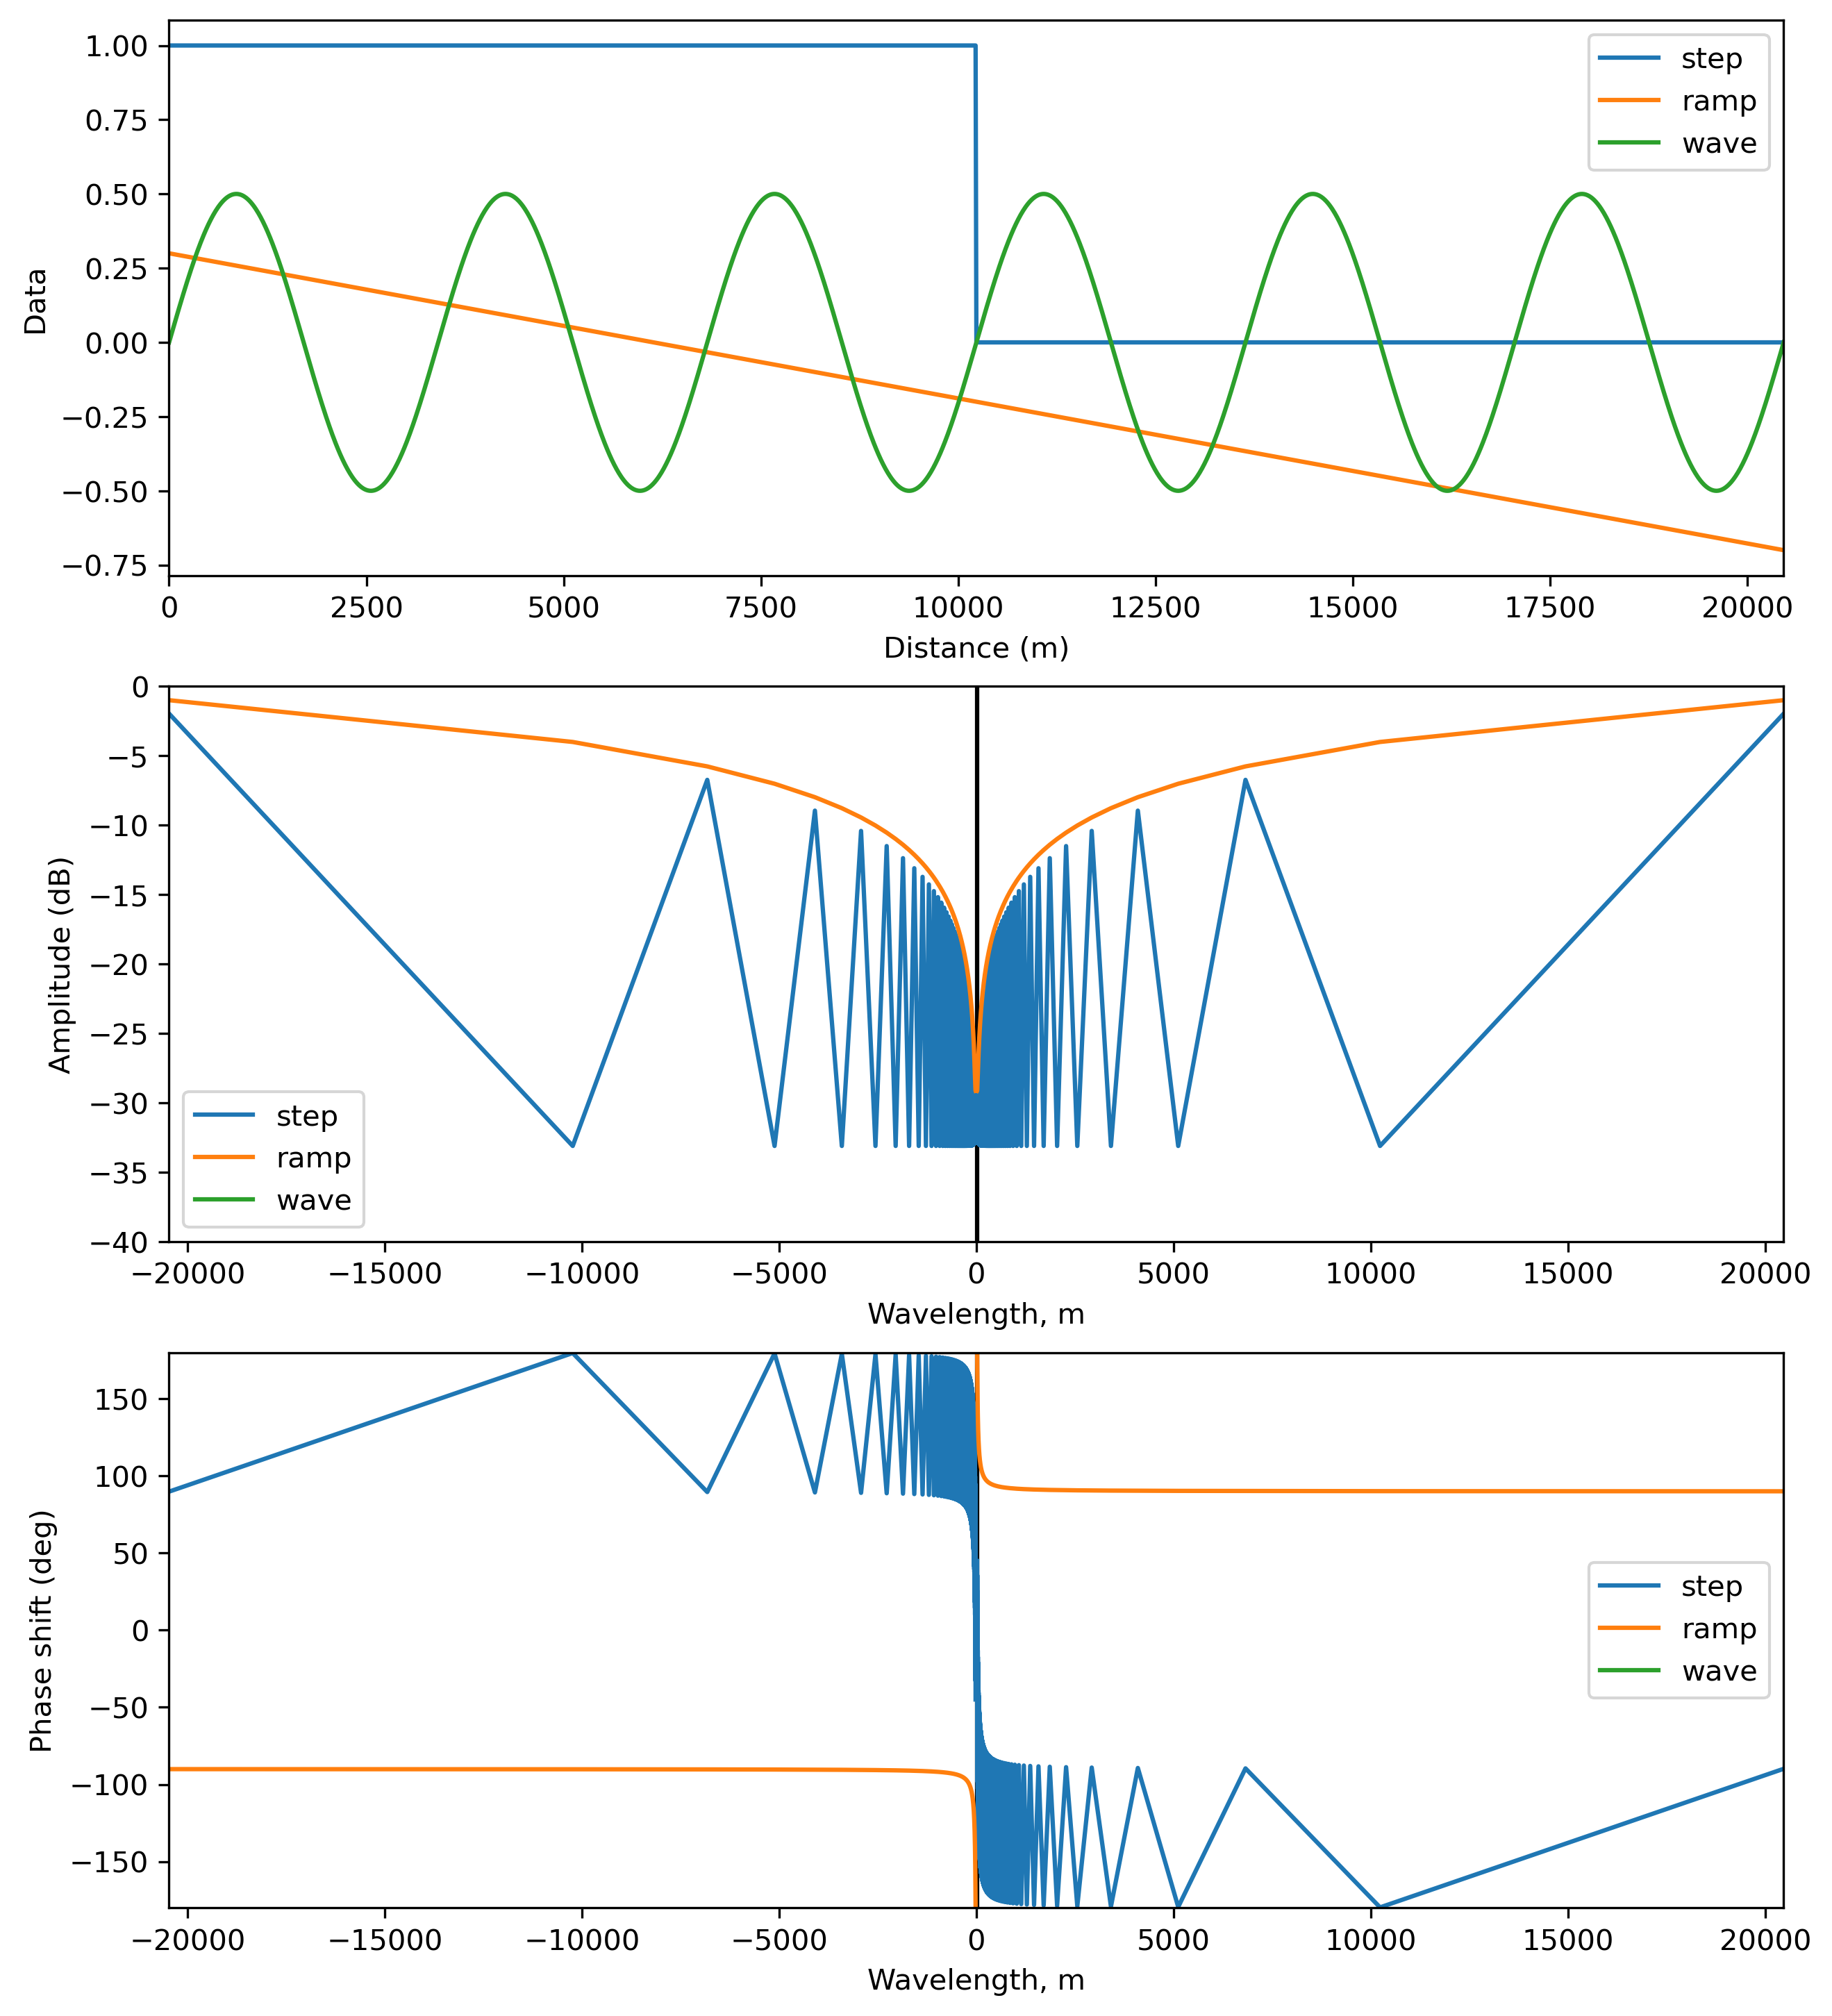

In [145]:
N = 2047
x = np.arange(N, dtype='f8')*delta
print(x.min(), x.max())

freqs = np.fft.fftfreq(N, delta)
df = freqs[1]-freqs[0]
# frequency interval is the same as that calculated theoretically from fs/N
print(df, fs/N)
# and so is the Nyquist
print(freqs.min(), freqs.max(), fn)

fftshift = np.fft.fftshift

def dB(a,base=1.0):
    return 10.0*np.log10(a/base)

def response_plot(signals, x, axs, freq, labels=None, wavelength=False, dB_amp=True):
    """ Signals is a tuple or list (or iterable) of signals.
    """
    
    if labels is None:
        labels = range(len(signals))
    ax_t, ax_f, ax_p = axs
    
    if wavelength:
        freqs = 1.0/freq
        freq_label = 'Wavelength, m' 
        fmin, fmax = np.nanmin(freqs), -np.nanmin(freqs)
        for ax in [ax_f, ax_p]: ax.axvline(Ln, color='k')
    else:
        freqs = freq
        freq_label = 'Spatial Frequency, m^-1' 
        fmin, fmax = np.nanmin(freqs), np.nanmax(freqs)
    print(fmin, fmax)
    
    for signal, label in zip(signals, labels):
        fft_s = np.fft.fft(signal/signal.sum(), signal.shape[0])
        amplitude = np.abs(fftshift(fft_s))
        amplitude /= amplitude.max()
        phase = np.angle(fftshift(fft_s))
        
#         print(amplitude.max(), amplitude.min(), np.all(~np.isfinite(amplitude)))
#         print(phase.max(), phase.min())

        ax_t.plot(x, signal, label=label)
        ax_t.set_ylabel('Data')
        ax_t.set_xlabel('Distance (m)')
        ax_t.set_xlim(x.min(), x.max())
        john = ax_t.legend()

        if dB_amp:
            ax_f.plot(fftshift(freqs), dB(amplitude), label=label)
            ax_f.set_ylim(-40,0)
            ax_f.set_ylabel('Amplitude (dB)')
        else:
            ax_f.plot(fftshift(freqs), amplitude, label=label)
            ax_f.set_ylim(0,1)
            ax_f.set_ylabel('Amplitude (linear)')
            tick_spacing = .05
            ax_f.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
            
        ax_f.set_xlim(fmin, fmax)
        ax_f.set_xlabel(freq_label)
        john = ax_f.legend()

        ax_p.plot(fftshift(freqs), np.degrees(phase), label=label)
        ax_p.set_ylim(-180,180)
        ax_p.set_xlim(fmin, fmax)
        ax_p.set_ylabel('Phase shift (deg)')
        ax_p.set_xlabel(freq_label)
        john = ax_p.legend()
        

fig, axes = plt.subplots(3,1, figsize=(10,12), dpi=300)

step = np.zeros_like(x)
step[:int(N/2)] = 1.0

ramp = -x/x.max() + 0.3

wave = np.sin(x*12*np.pi/x.max())/2

signals = [step, ramp, wave]
labels = ['step', 'ramp', 'wave']

response_plot(signals[:], x, axes, freqs, labels=labels[:], wavelength=True)

[False False False ... False False False]
[False False False ... False False False]
-20470.0 20470.0


<ipython-input-145-d50f626f42f1>:26: RuntimeWarning: divide by zero encountered in true_divide
  freqs = 1.0/freq


(0.0, 200.0)

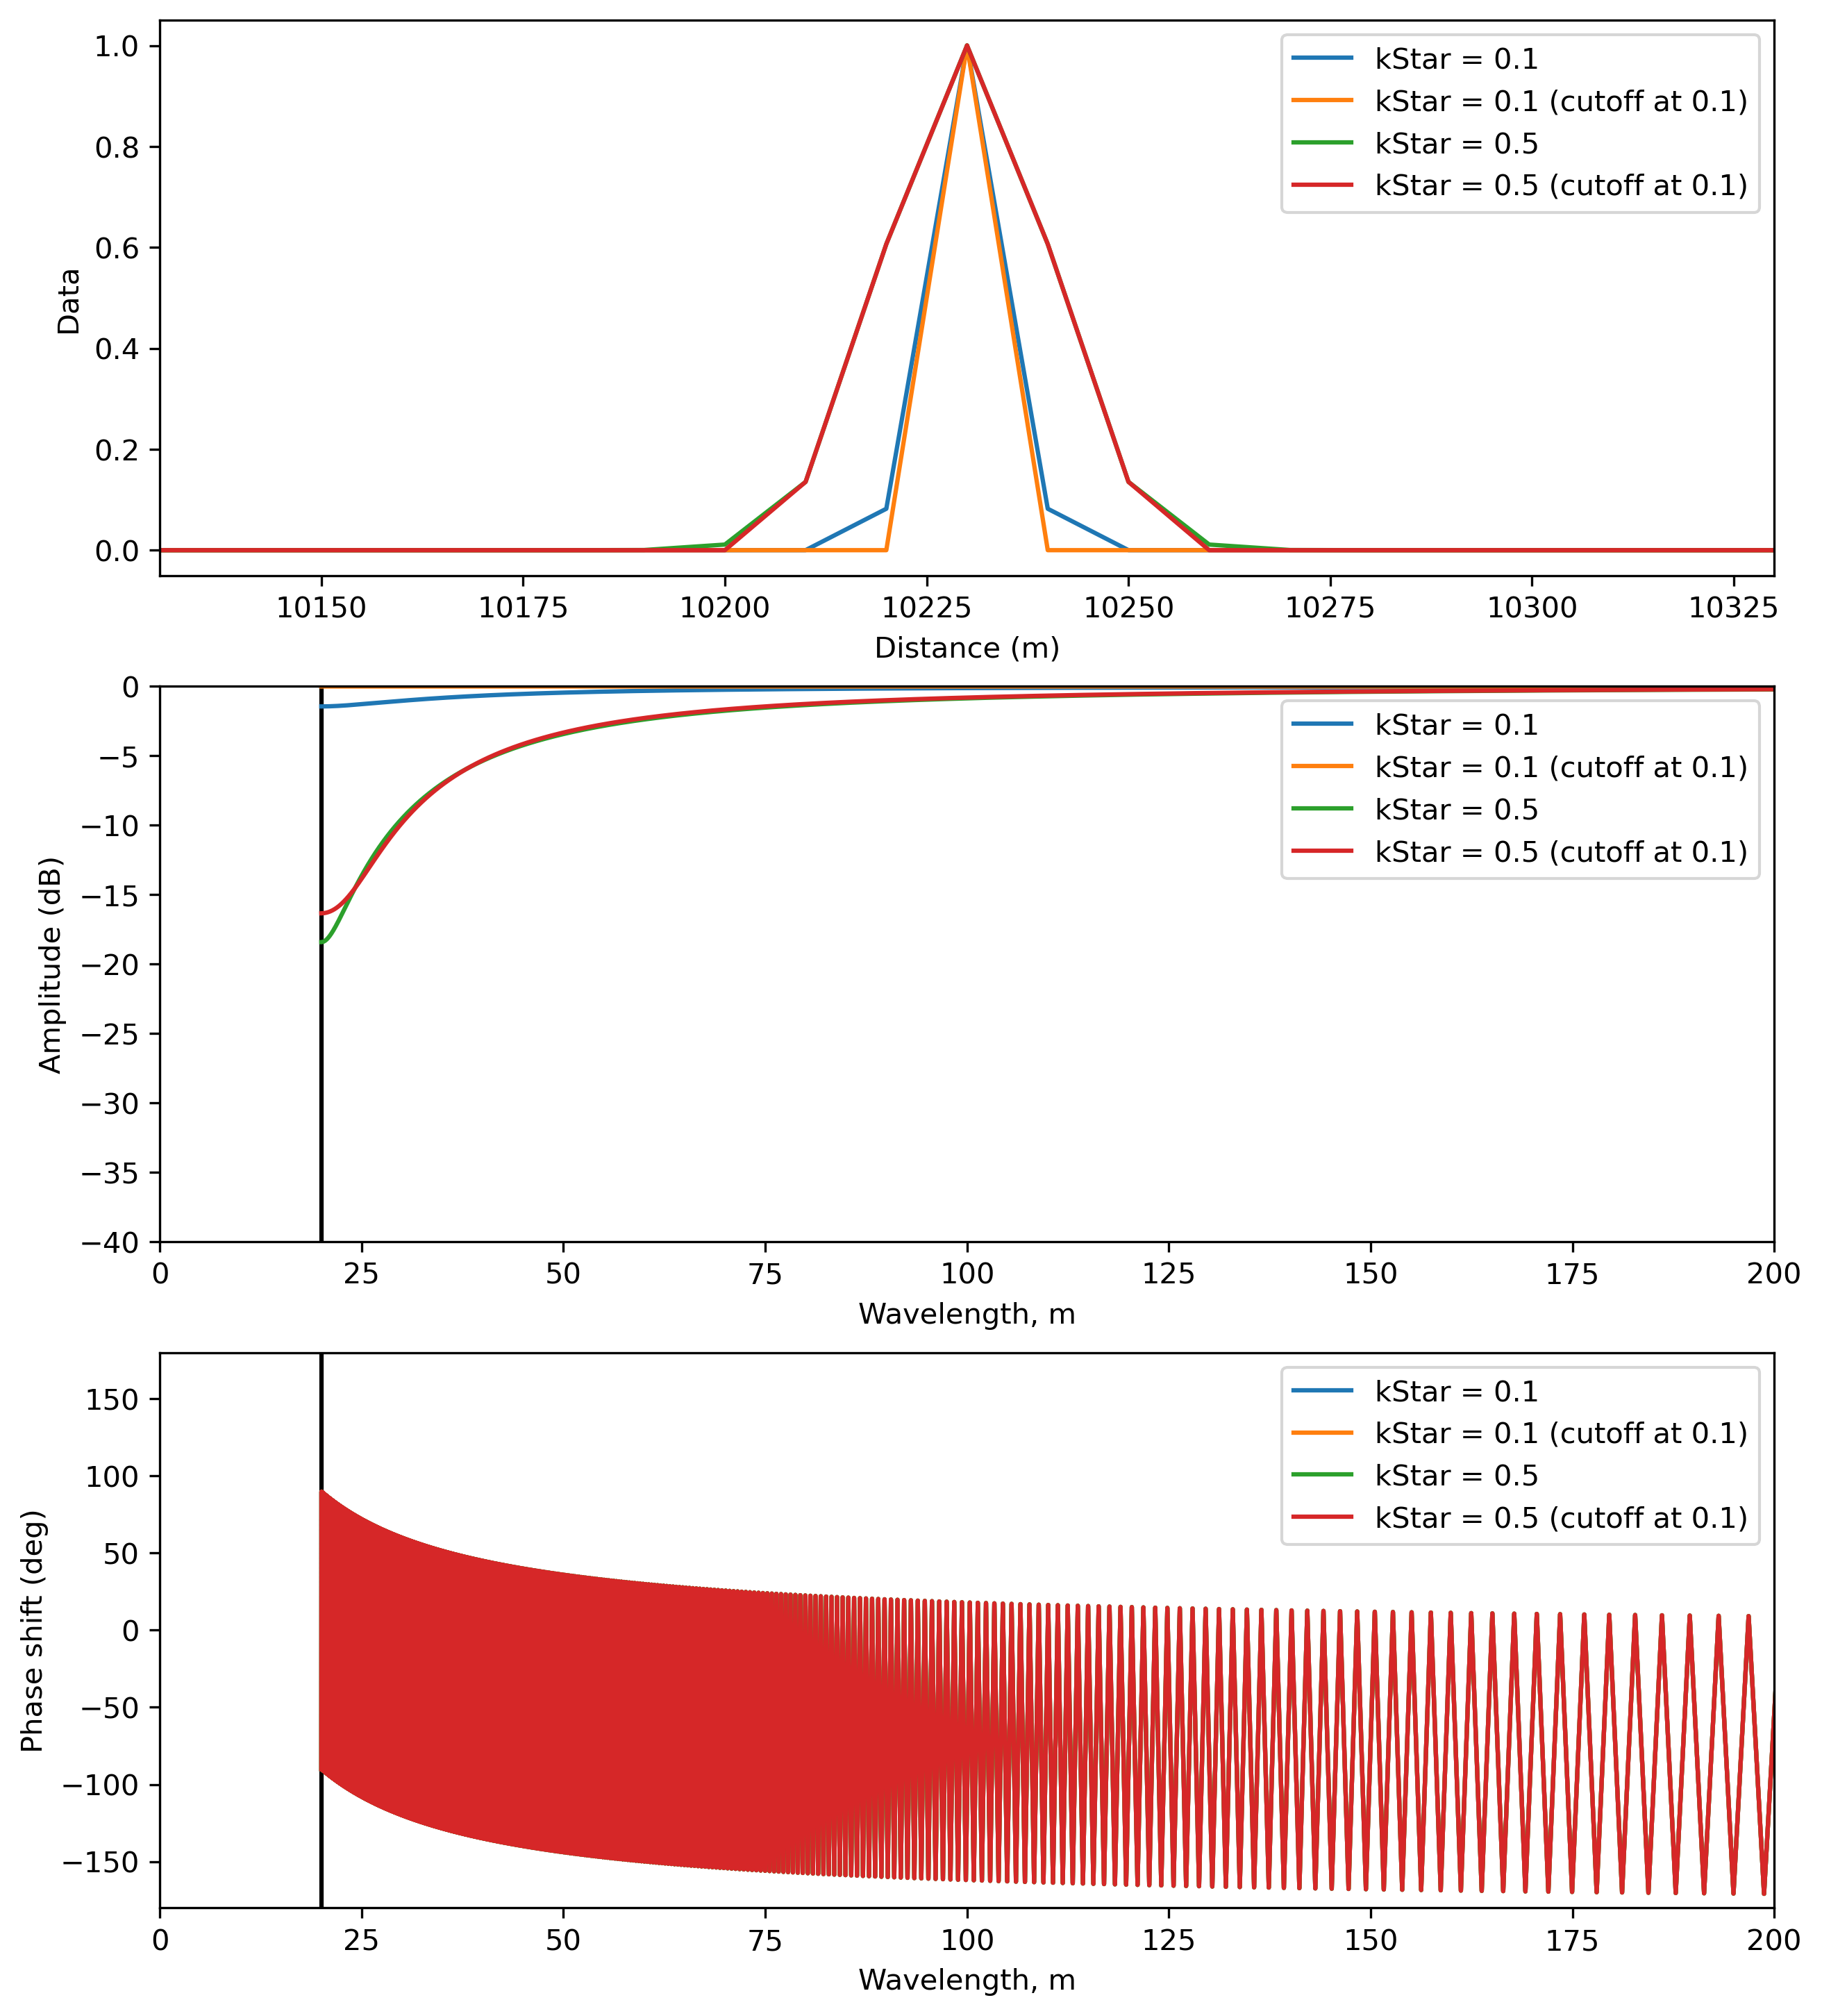

In [146]:
def barnes(r, k):
    """ r has units of distance, and k is the dimensional weight parameter kappa
        kappa with units of distance squared.
        
        Returns the weights as a funcion of r.
    """
    return np.exp((-np.square(r))/k)

# weight functions (4)
k1=0.1
k2=0.5

def cutoff(w,coffVal = 0.1): 
    print(np.greater_equal(w,coffVal))
    return (np.greater_equal(w,coffVal))*w

def kappa(kStar,Ln): 
    return kStar*np.square(Ln)

# Center the gaussians on the middle of data set
b1 = barnes(x-x.max()/2, kappa(k1,Ln))
b2 = barnes(x-x.max()/2, kappa(k2,Ln))

b1cut = cutoff(b1)
b2cut = cutoff(b2)

fig, axes = plt.subplots(3,1, figsize=(10,12), dpi=300)

signals = [b1,b1cut,b2,b2cut]
labels = ['kStar = 0.1', 'kStar = 0.1 (cutoff at 0.1)', 'kStar = 0.5', 'kStar = 0.5 (cutoff at 0.1)']

response_plot(signals[:], x, axes, freqs, labels=labels[:], wavelength=True)
axes[0].set_xlim(x.max()/2-100, x.max()/2+100)
axes[1].set_xlim(0,200)
axes[2].set_xlim(0,200)

[False False False ... False False False]
[False False False ... False False False]
-20470.0 20470.0


<ipython-input-145-d50f626f42f1>:26: RuntimeWarning: divide by zero encountered in true_divide
  freqs = 1.0/freq


(0.0, 200.0)

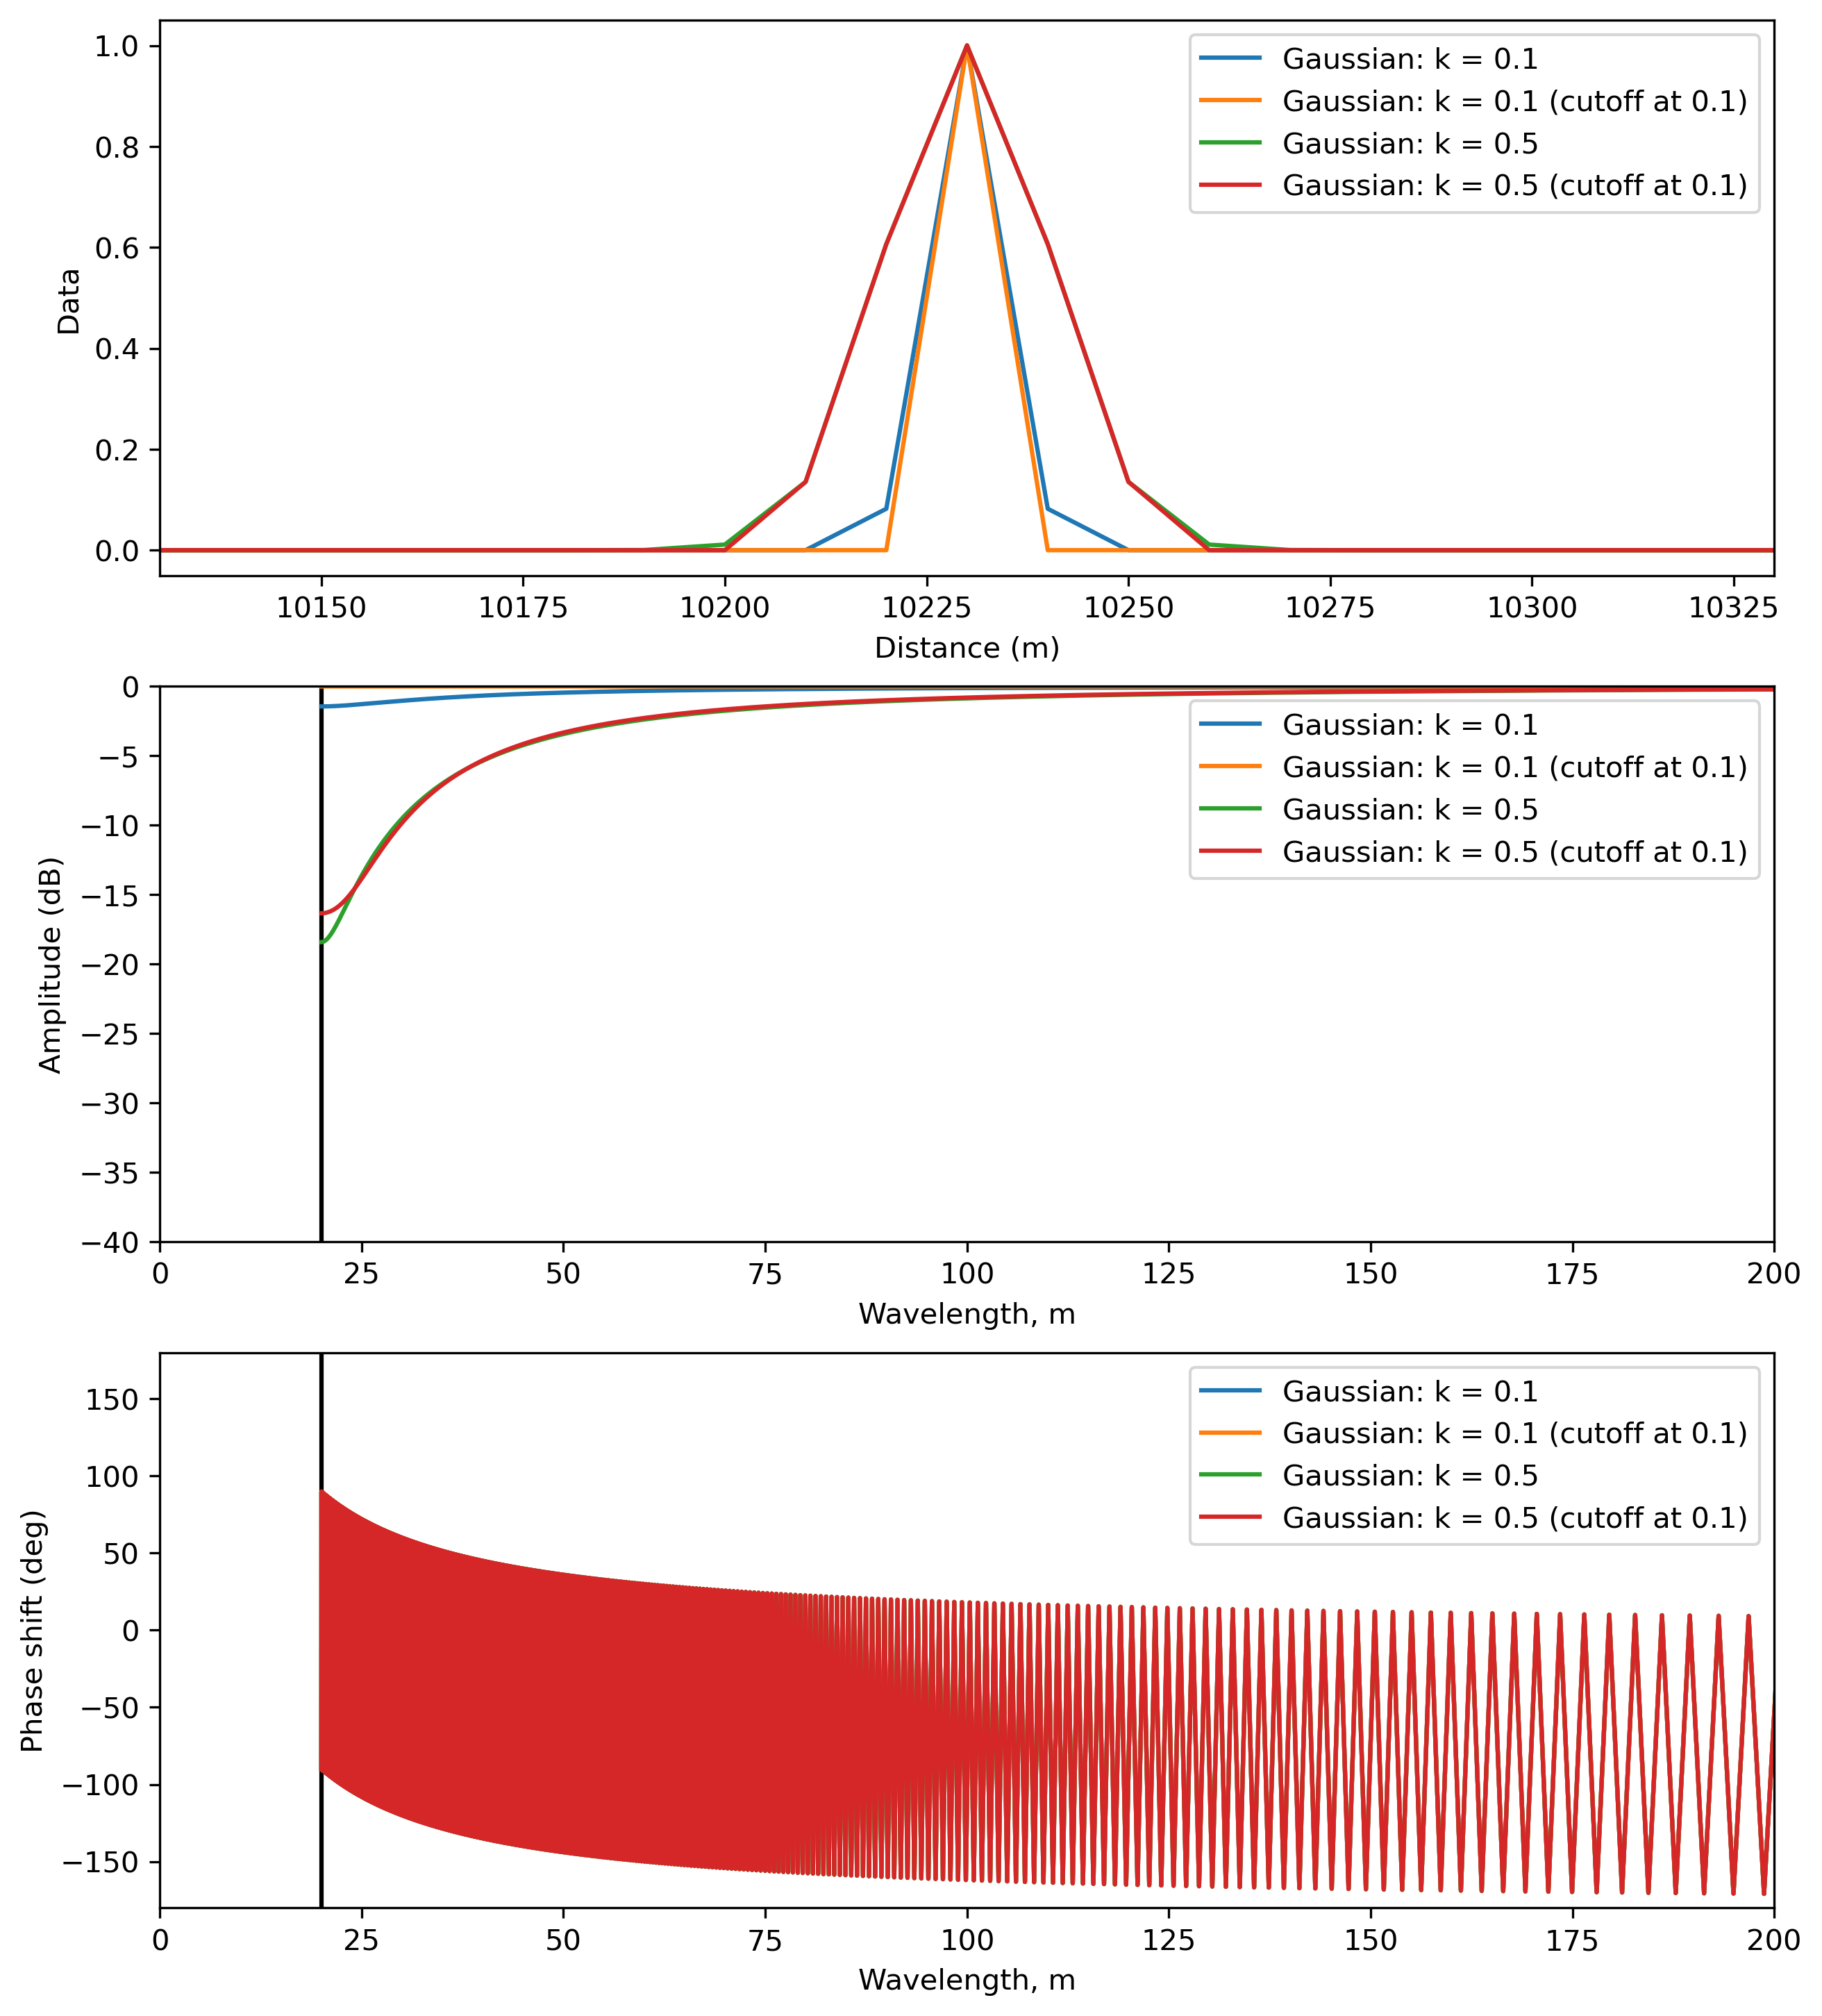

In [148]:
from scipy.signal.windows import gaussian

def sigma(kStar):
    return np.sqrt(2*kStar)

g1 = gaussian(N, sigma(k1))
g2 = gaussian(N, sigma(k2))

g1cut = cutoff(g1)
g2cut = cutoff(g2)

fig, axes = plt.subplots(3,1, figsize=(10,12), dpi=300)

signals = [g1,g1cut,g2,g2cut]
labels = ['Gaussian: k = 0.1', 'Gaussian: k = 0.1 (cutoff at 0.1)',
          'Gaussian: k = 0.5', 'Gaussian: k = 0.5 (cutoff at 0.1)']

response_plot(signals[:], x, axes, freqs, labels=labels[:], wavelength=True)
axes[0].set_xlim(x.max()/2-100, x.max()/2+100)
axes[1].set_xlim(0,200)
axes[2].set_xlim(0,200)


200
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20
 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44
 45 46 47 48  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
2047
2047
-20470.0 20470.0


<ipython-input-149-358f70be86d4>:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nPad = np.int(N-n)
<ipython-input-149-358f70be86d4>:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details 

(0.0, 200.0)

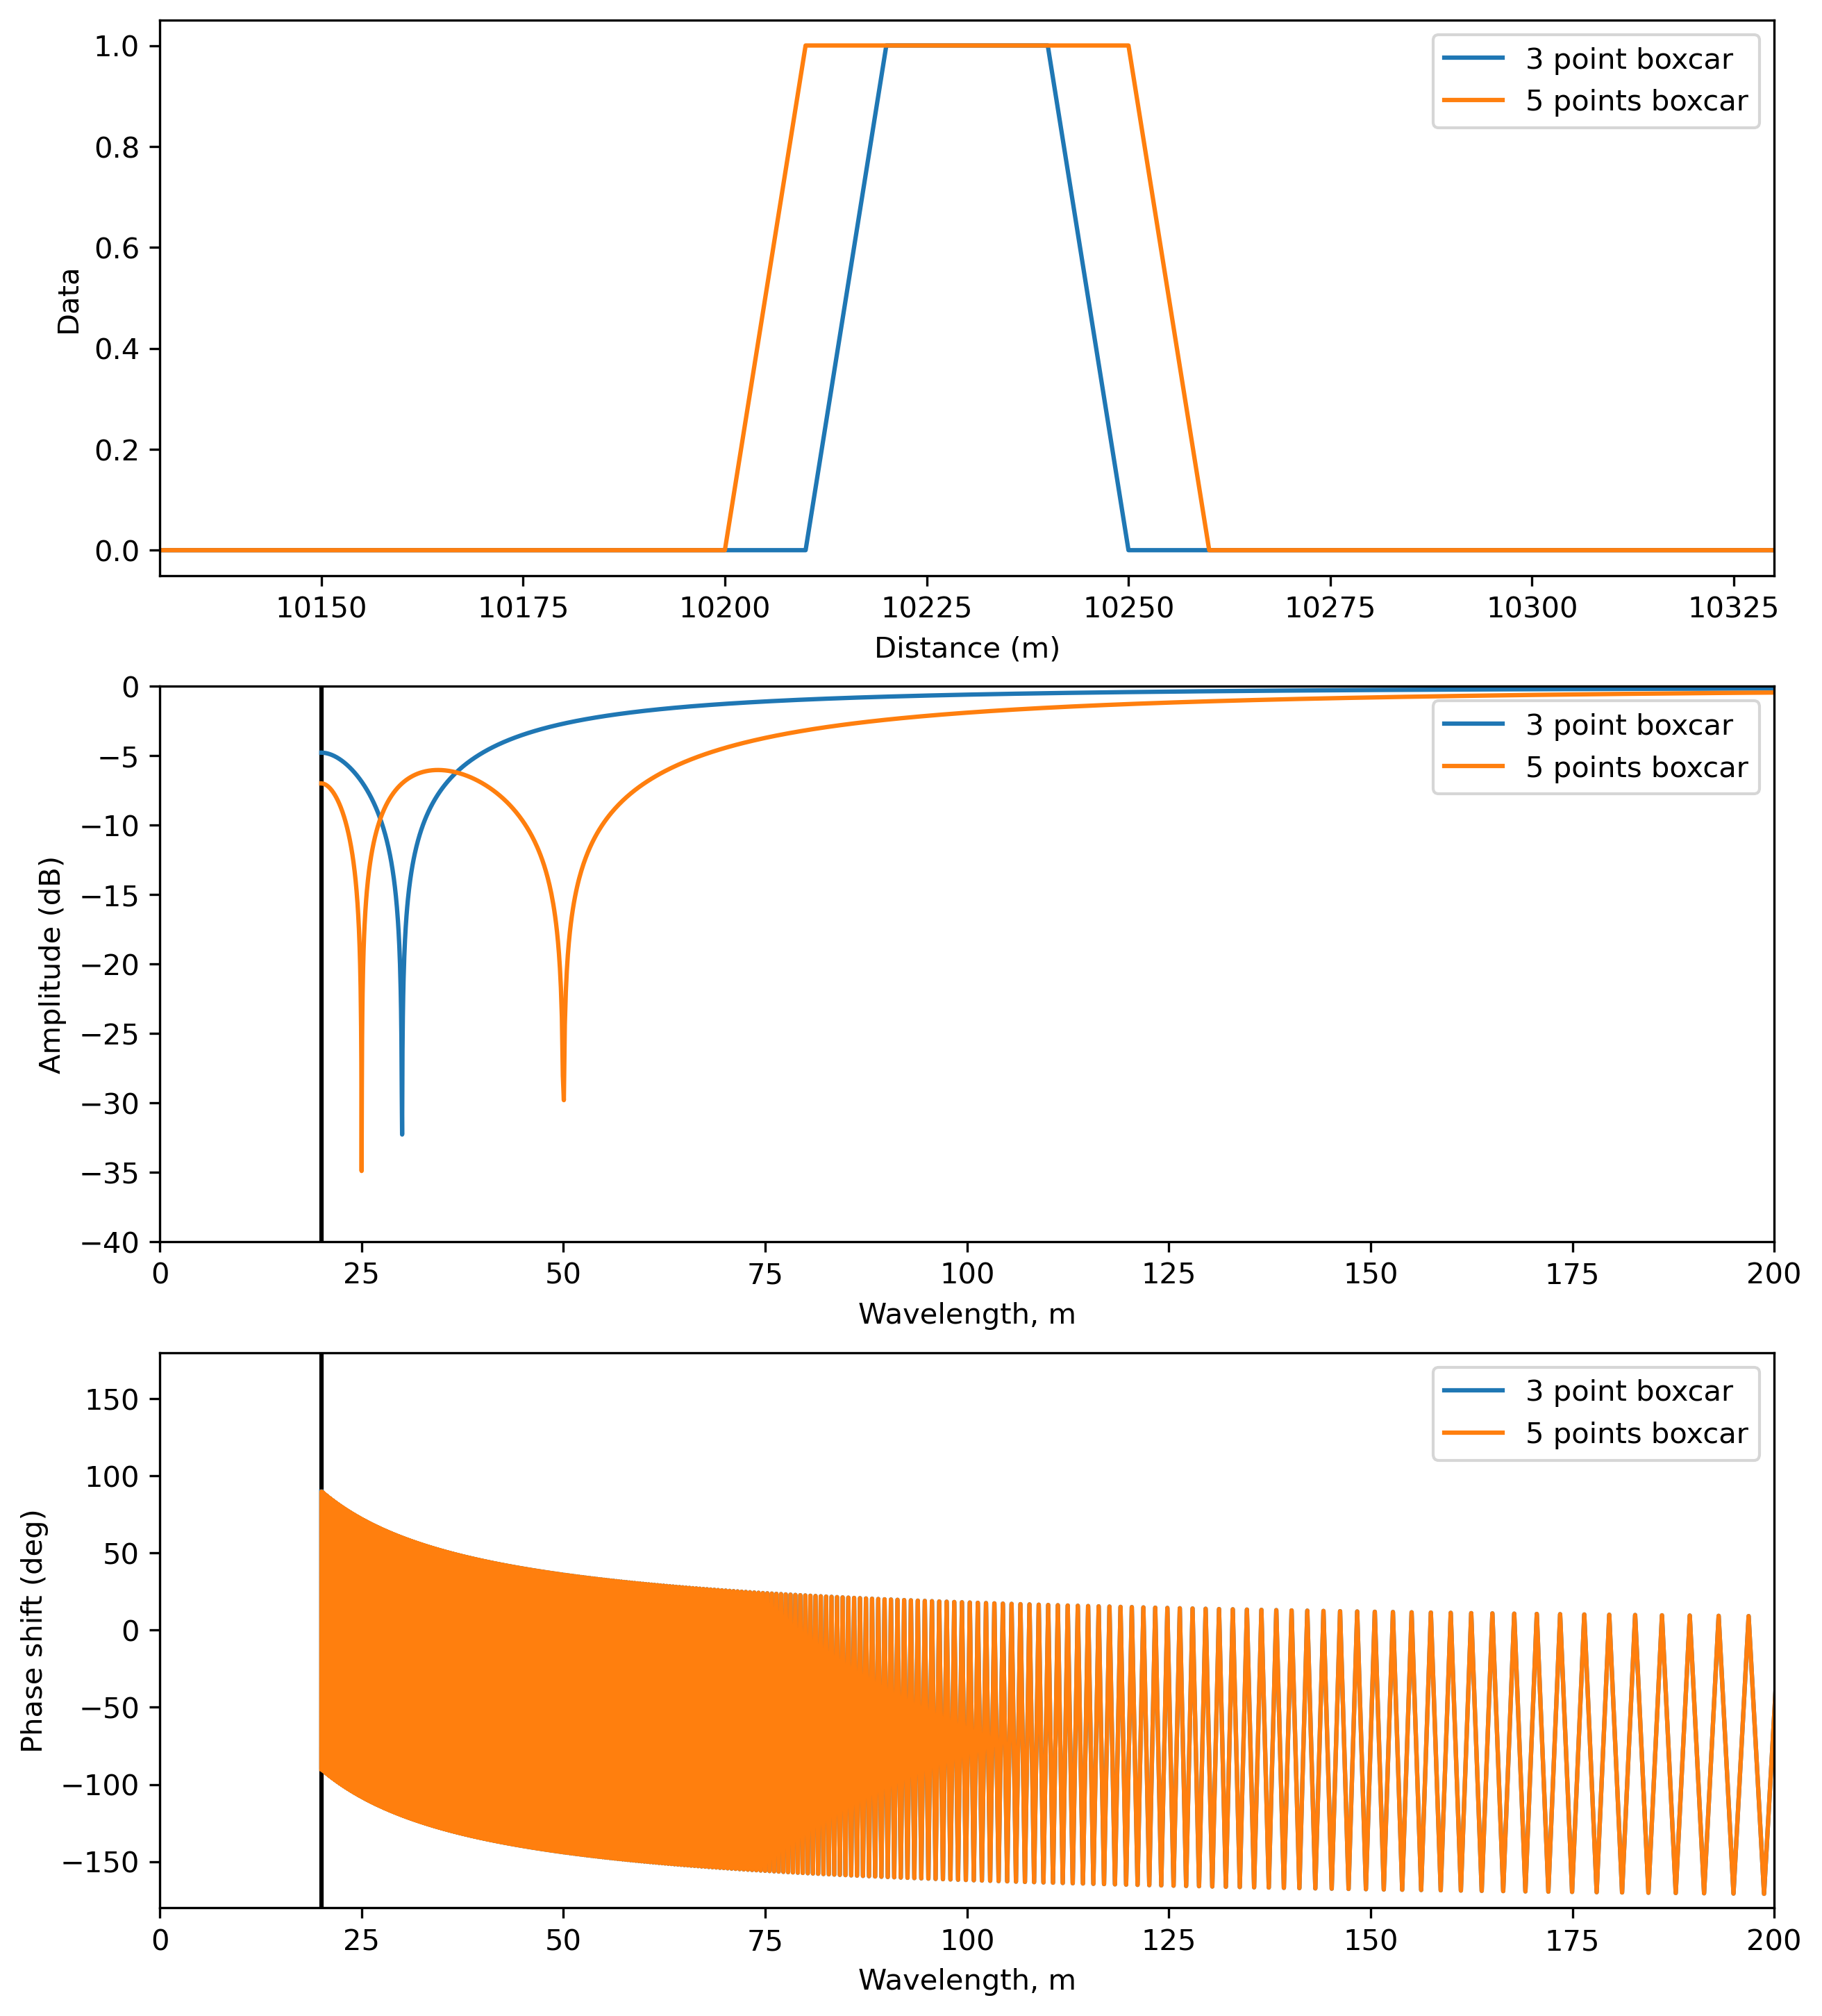

In [149]:
def centeredZeroPad(x,N):
    """
    Pad a 1D array of length n with zeros such
    that it is centered in an array with length N
    """
    n = x.size
    print(N)
    if n >= N:
        # Do no padding and return if n is not less than N
        return x
    
    # Total number of zeros to pad
    nPad = np.int(N-n)
    
    # Number of zeros to pad on the left
    leftN = np.int(np.ceil(nPad/2))
    
    # And the right
    rightN = nPad-leftN
    
    return np.pad(x,(leftN,rightN),mode="constant")

print(centeredZeroPad(np.arange(1,49),200))

from scipy.signal import boxcar

box1 = boxcar(3)
box2 = boxcar(5)
box1 = centeredZeroPad(box1,N)
box2 = centeredZeroPad(box2,N)

fig, axes = plt.subplots(3,1, figsize=(10,12), dpi=300)

signals = [box1, box2]
labels = ['3 point boxcar', '5 points boxcar']

response_plot(signals[:], x, axes, freqs, labels=labels[:], wavelength=True)

# Manually set xlim 
axes[0].set_xlim(x.max()/2-100, x.max()/2+100)
axes[1].set_xlim(0,200)
axes[2].set_xlim(0,200)

2047
[False False False ... False False False]
-20470.0 20470.0


<ipython-input-149-358f70be86d4>:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nPad = np.int(N-n)
<ipython-input-149-358f70be86d4>:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details 

(0.0, 200.0)

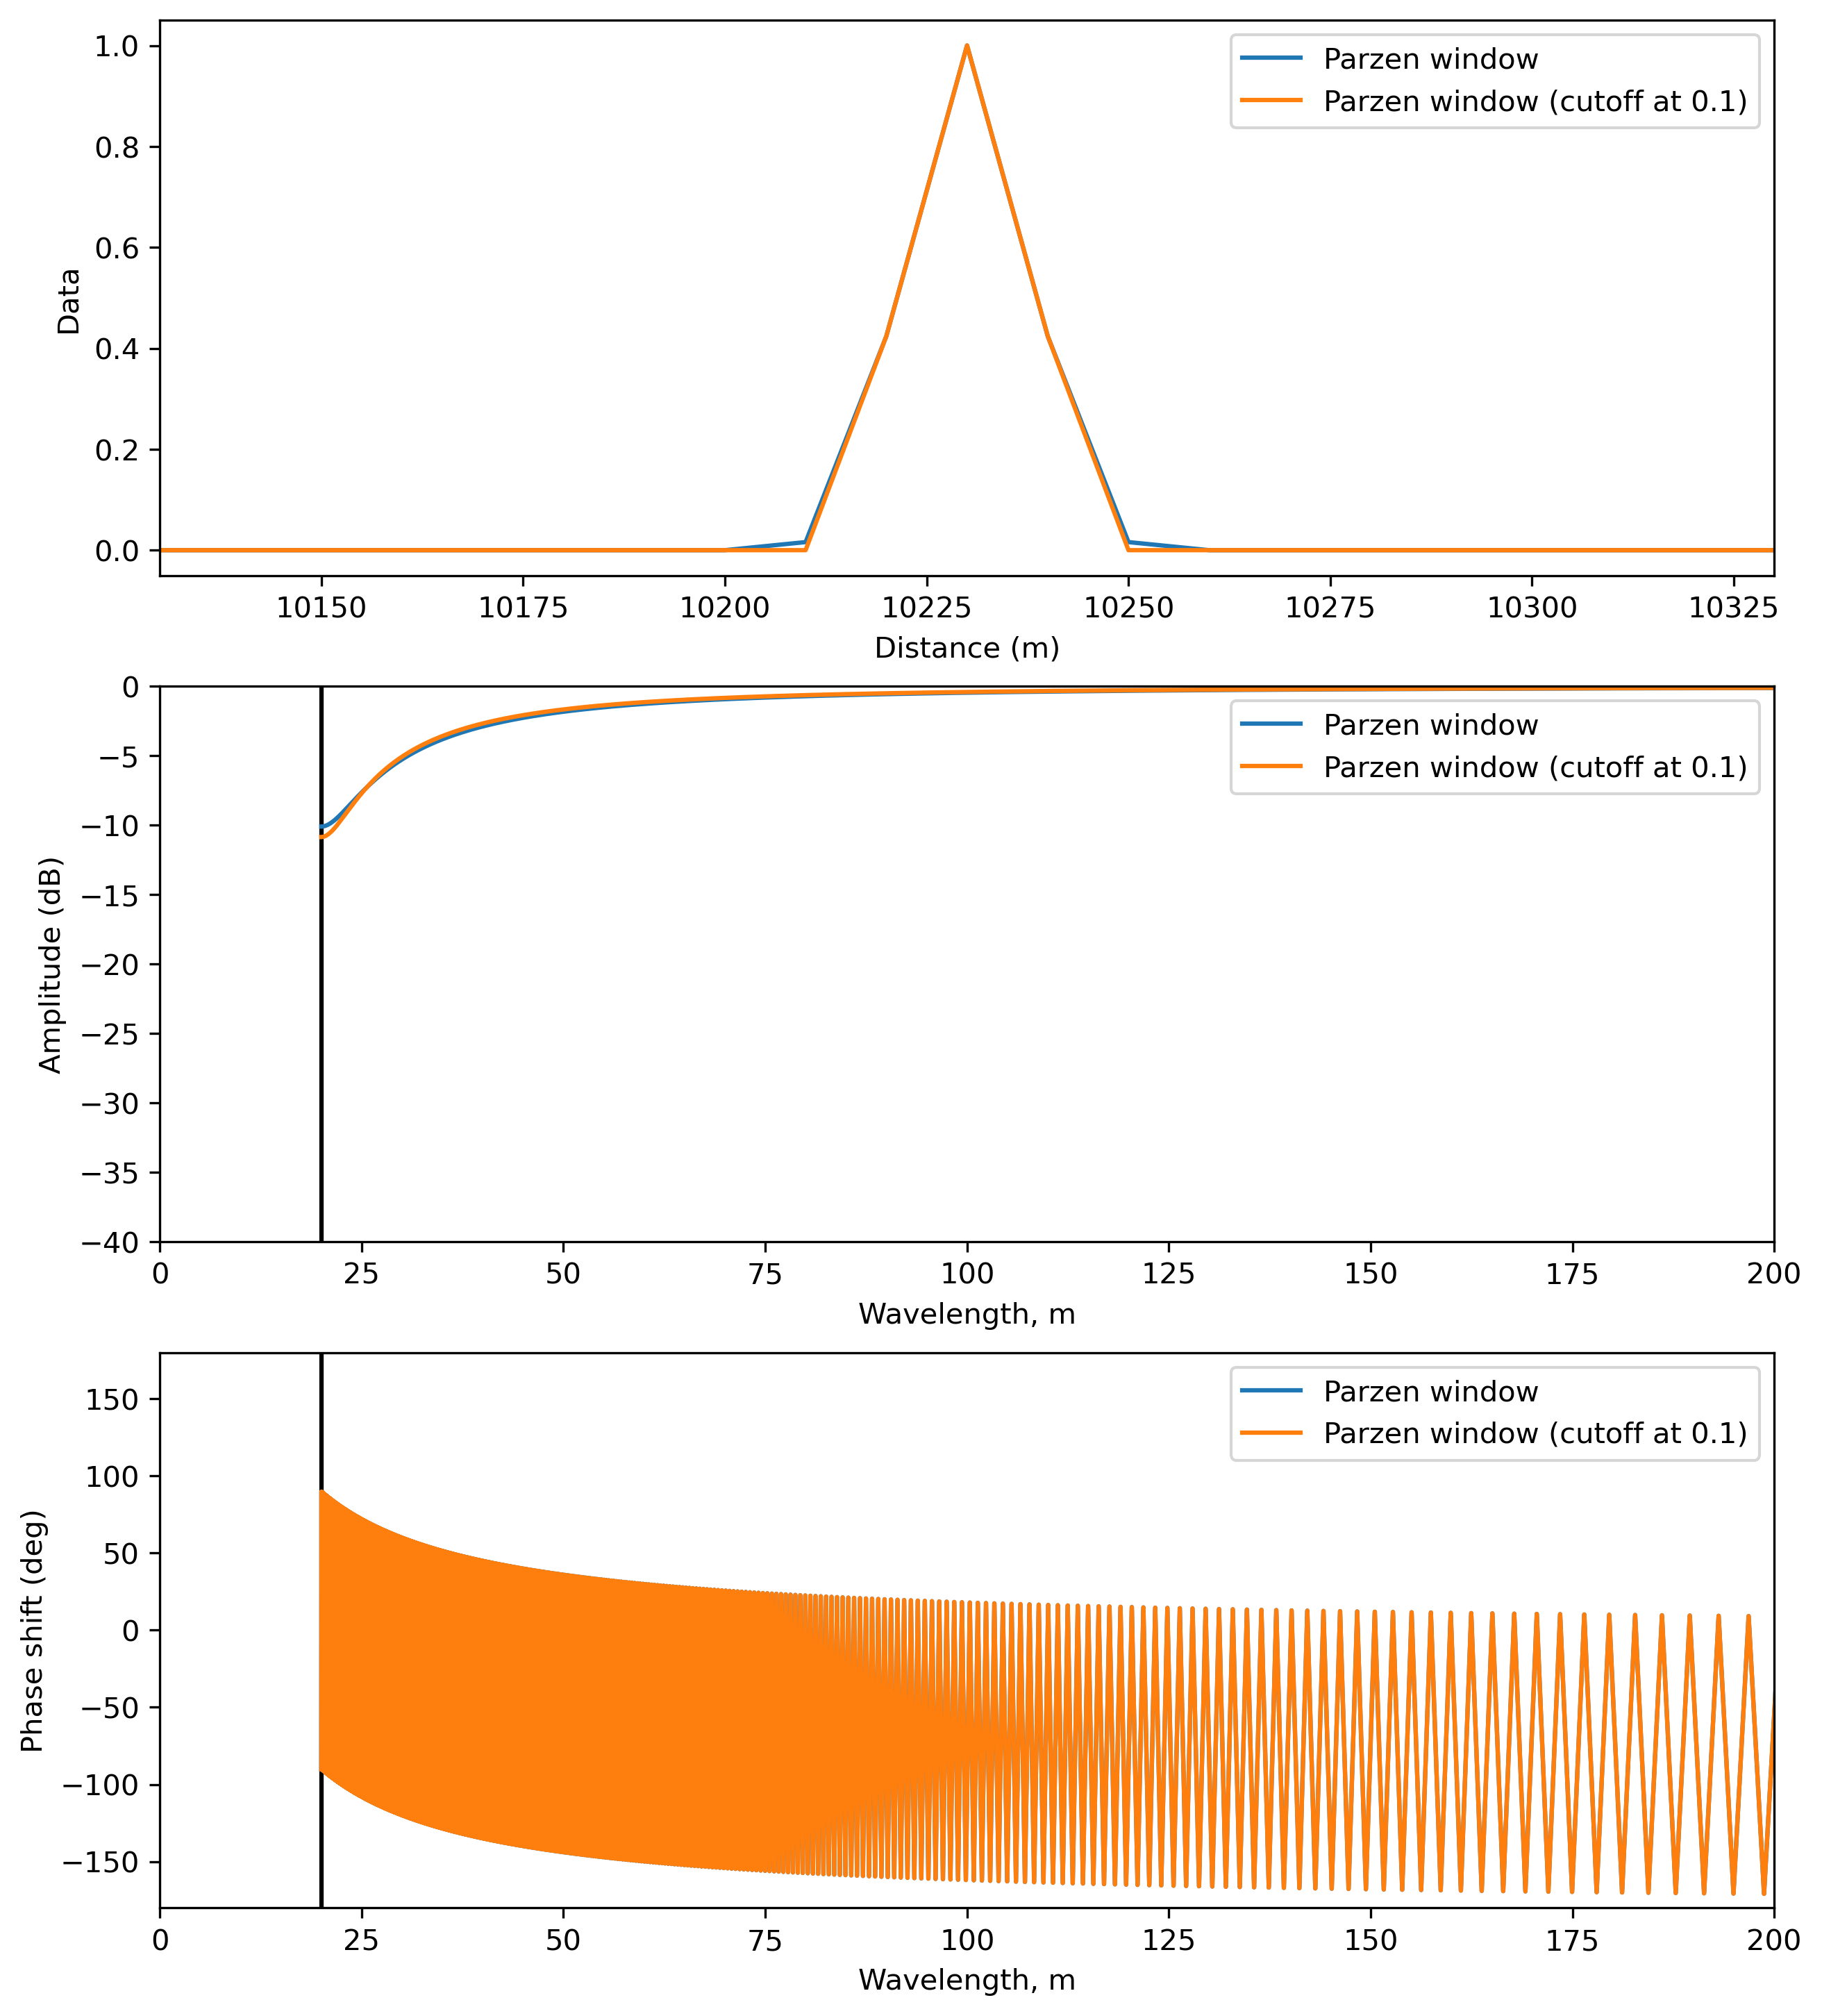

In [150]:
from scipy.signal.windows import parzen

p = centeredZeroPad(parzen(5),N)
pCut = cutoff(p,0.1)

fig, axes = plt.subplots(3,1, figsize=(10,12), dpi=300)

signals = [p, pCut]
labels = ['Parzen window', 'Parzen window (cutoff at 0.1)']

response_plot(signals[:], x, axes, freqs, labels=labels[:], wavelength=True)
axes[0].set_xlim(x.max()/2-100, x.max()/2+100)
axes[1].set_xlim(0,200)
axes[2].set_xlim(0,200)

2047
[False False False ... False False False]
-20470.0 20470.0


<ipython-input-149-358f70be86d4>:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nPad = np.int(N-n)
<ipython-input-149-358f70be86d4>:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details 

(0.0, 200.0)

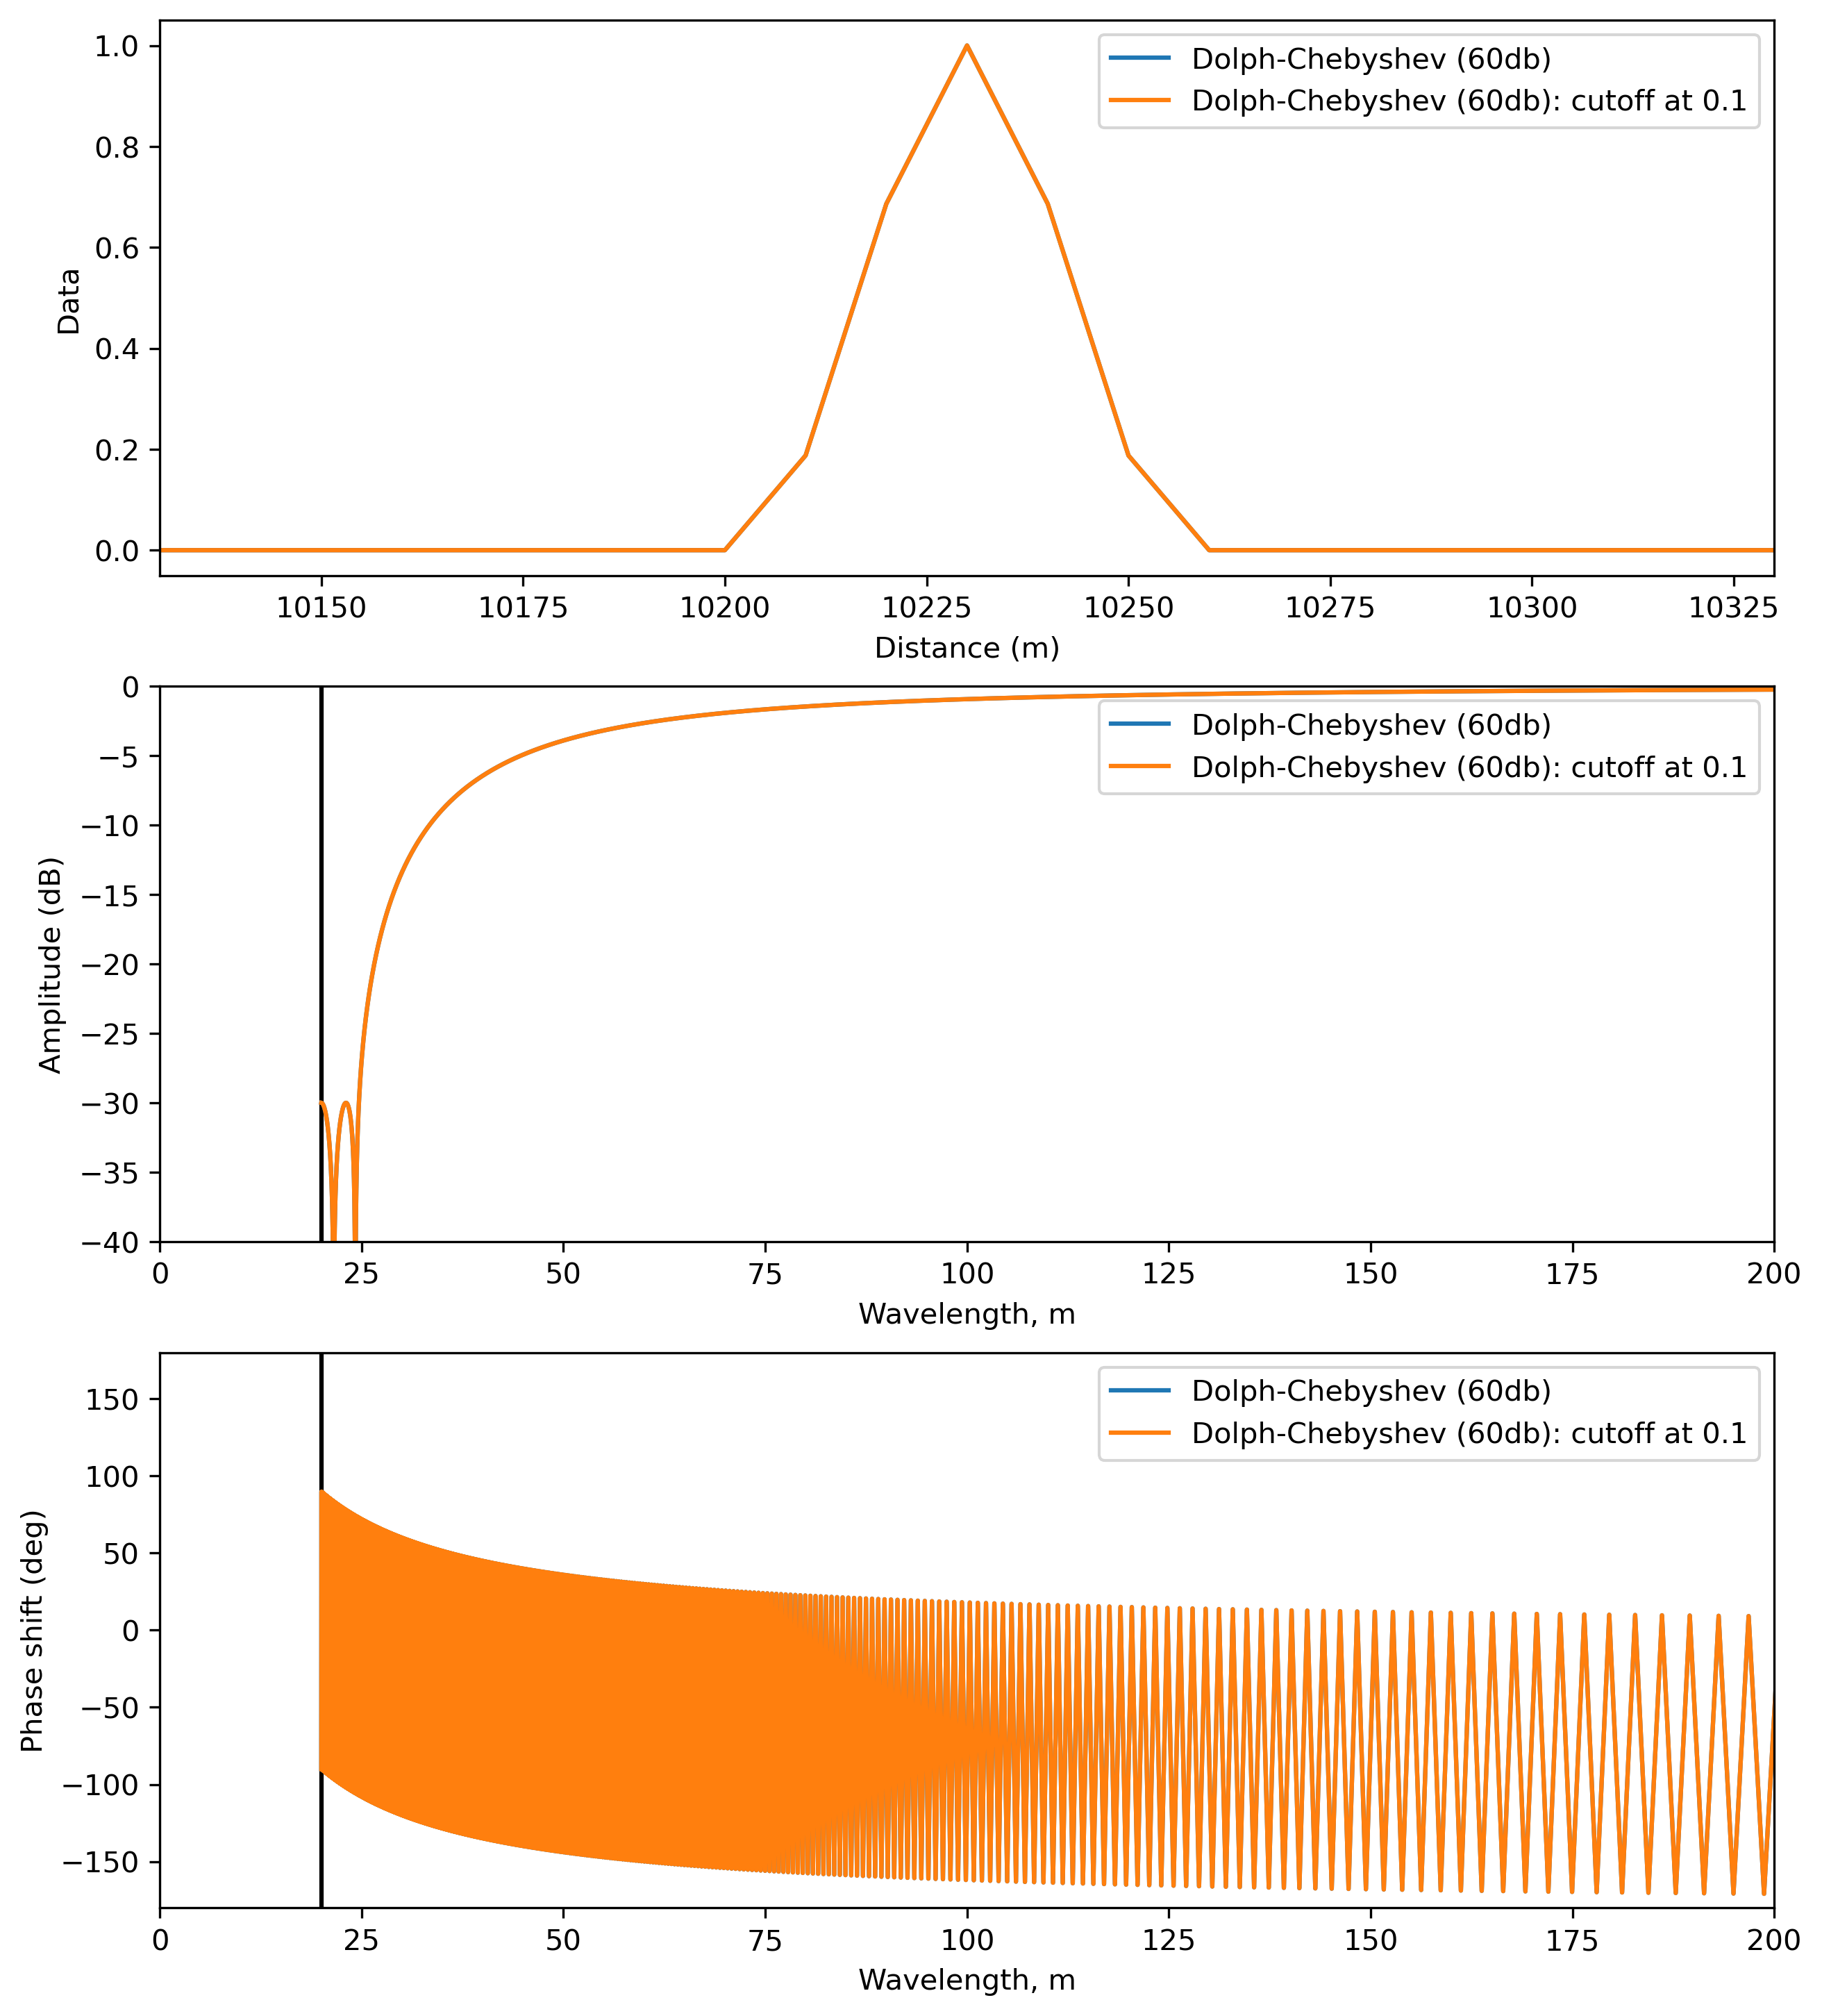

In [151]:
from scipy.signal.windows import chebwin

cheb = centeredZeroPad(chebwin(5,at=60),N)
chebCut = cutoff(cheb,0.1)

fig, axes = plt.subplots(3,1, figsize=(10,12), dpi=300)

signals = [cheb, chebCut]
labels = ['Dolph-Chebyshev (60db)', 'Dolph-Chebyshev (60db): cutoff at 0.1']

response_plot(signals[:], x, axes, freqs, labels=labels[:], wavelength=True)
axes[0].set_xlim(x.max()/2-100, x.max()/2+100)
axes[1].set_xlim(0,200)
axes[2].set_xlim(0,200)

2047
2047
-20470.0 20470.0


<ipython-input-149-358f70be86d4>:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nPad = np.int(N-n)
<ipython-input-149-358f70be86d4>:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details 

(0.0, 200.0)

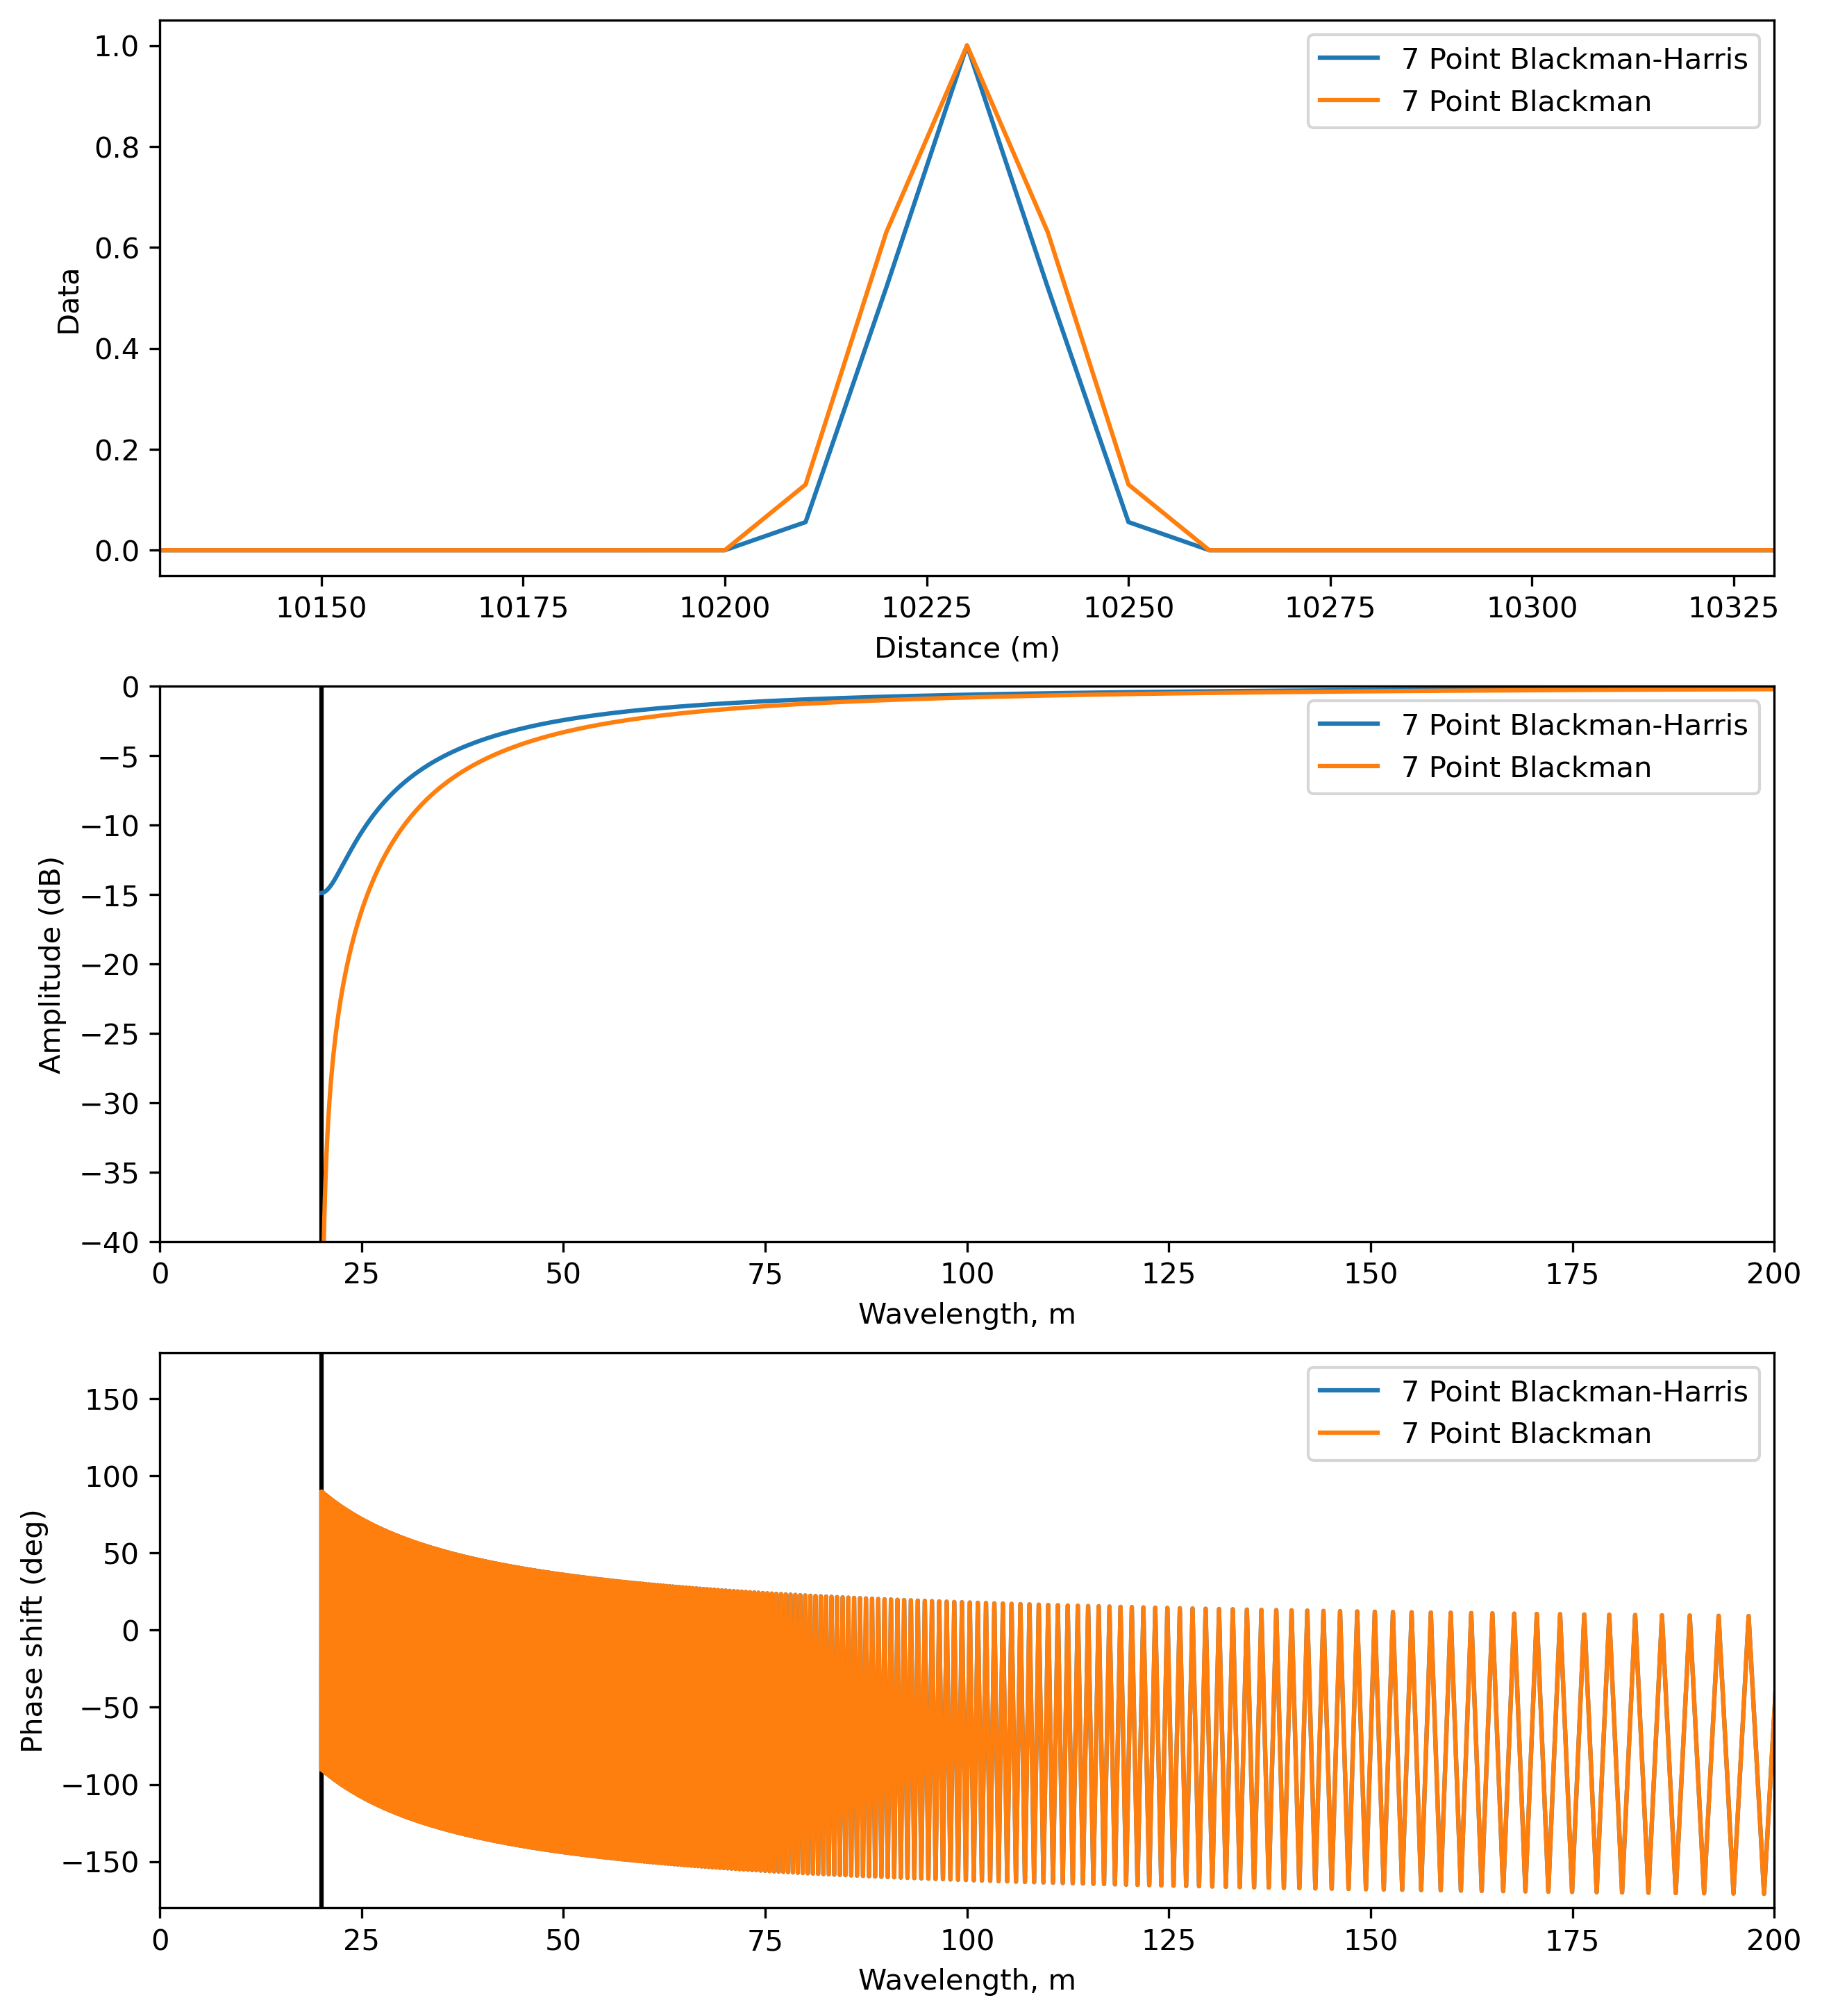

In [152]:
from scipy.signal.windows import blackmanharris, blackman

bmh = centeredZeroPad(blackmanharris(7),N)

bm = centeredZeroPad(blackman(7),N)

fig, axes = plt.subplots(3,1, figsize=(10,12), dpi=300)

signals = [bmh, bm]
labels = ['7 Point Blackman-Harris', '7 Point Blackman']

response_plot(signals[:], x, axes, freqs, labels=labels[:], wavelength=True)
axes[0].set_xlim(x.max()/2-100, x.max()/2+100)
axes[1].set_xlim(0,200)
axes[2].set_xlim(0,200)

-20470.0 20470.0


<ipython-input-145-d50f626f42f1>:26: RuntimeWarning: divide by zero encountered in true_divide
  freqs = 1.0/freq
<ipython-input-153-a2660a17c6fb>:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  axes[0].set_xlim(x[np.int((N-1)/2-15)],x[np.int((N-1)/2+15)])


(0.0, 200.0)

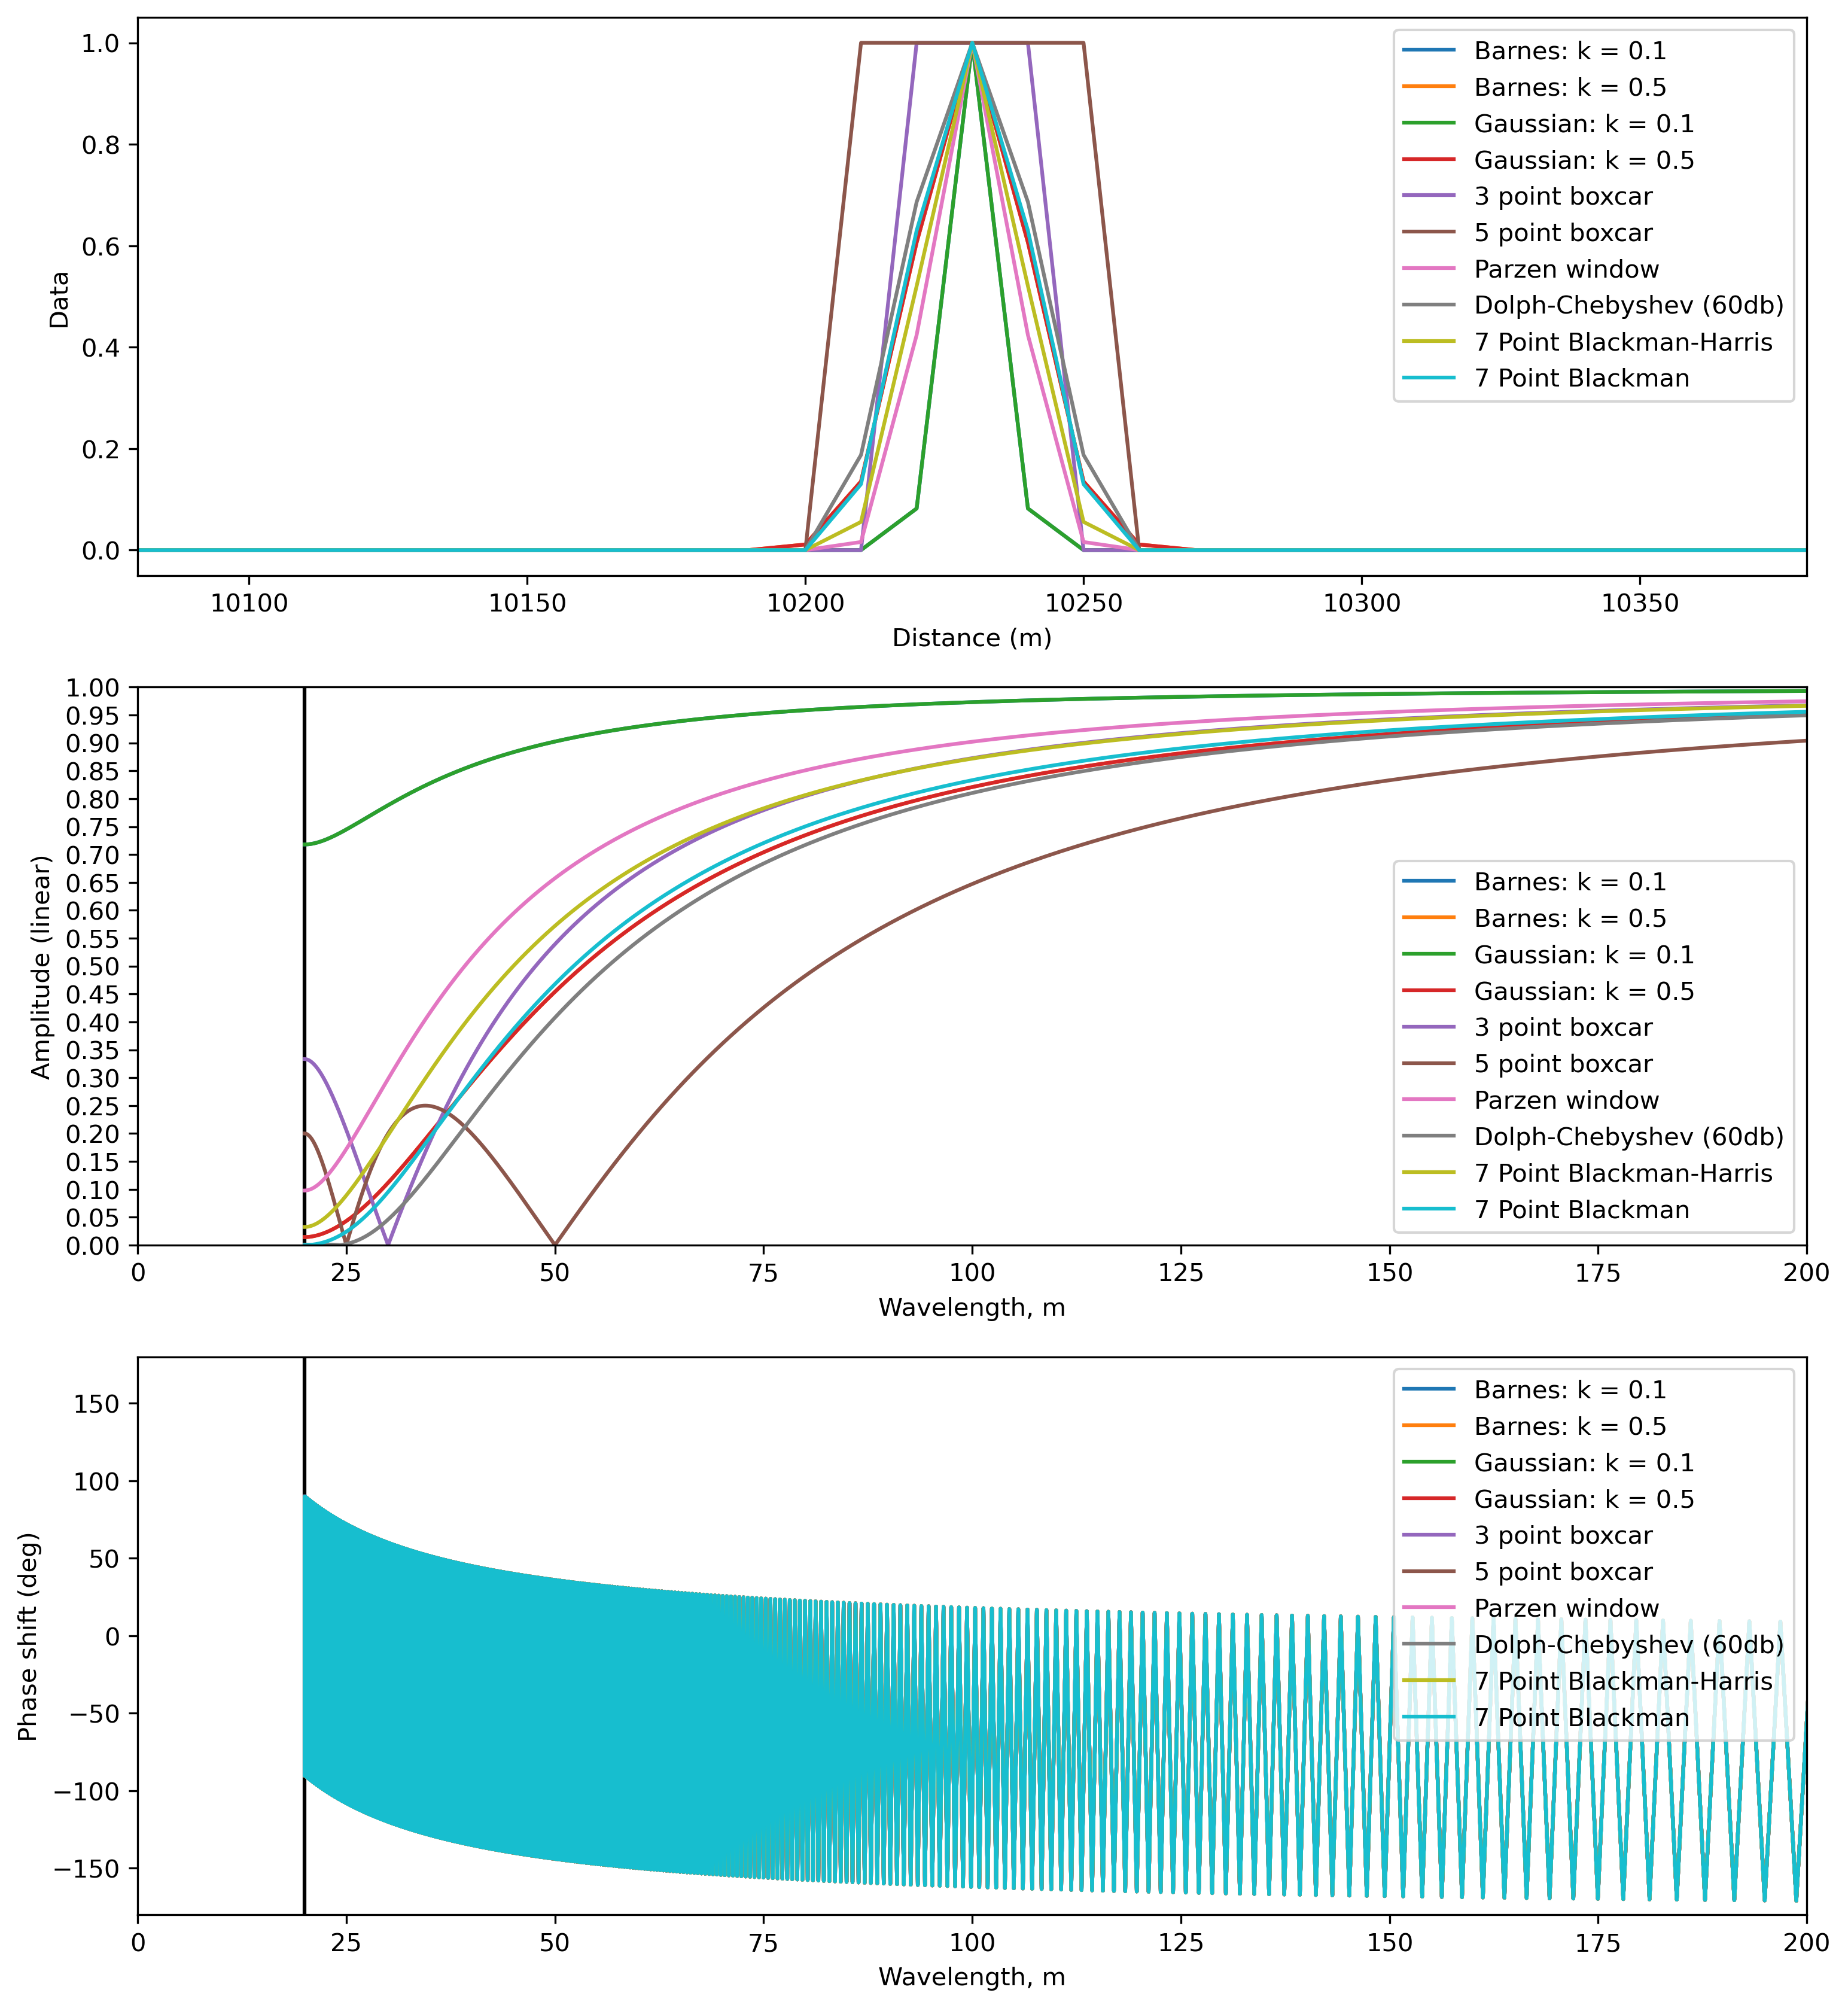

In [153]:
fig, axes = plt.subplots(3,1, figsize=(12,14), dpi=300)

signals = [b1, b2, g1, g2, box1, box2, p, cheb, bmh, bm]
labels = ['Barnes: k = 0.1','Barnes: k = 0.5','Gaussian: k = 0.1', 'Gaussian: k = 0.5',
          '3 point boxcar', '5 point boxcar',
          'Parzen window', 'Dolph-Chebyshev (60db)',
          '7 Point Blackman-Harris', '7 Point Blackman']

response_plot(signals[:], x, axes, freqs, labels=labels[:], wavelength=True, dB_amp=False)

axes[0].set_xlim(x[np.int((N-1)/2-15)],x[np.int((N-1)/2+15)])
axes[1].set_xlim(0,200)
axes[2].set_xlim(0,200)


[False False False ... False False False]
[False False False ... False False False]
-20470.0 20470.0


<ipython-input-145-d50f626f42f1>:26: RuntimeWarning: divide by zero encountered in true_divide
  freqs = 1.0/freq


(0.0, 200.0)

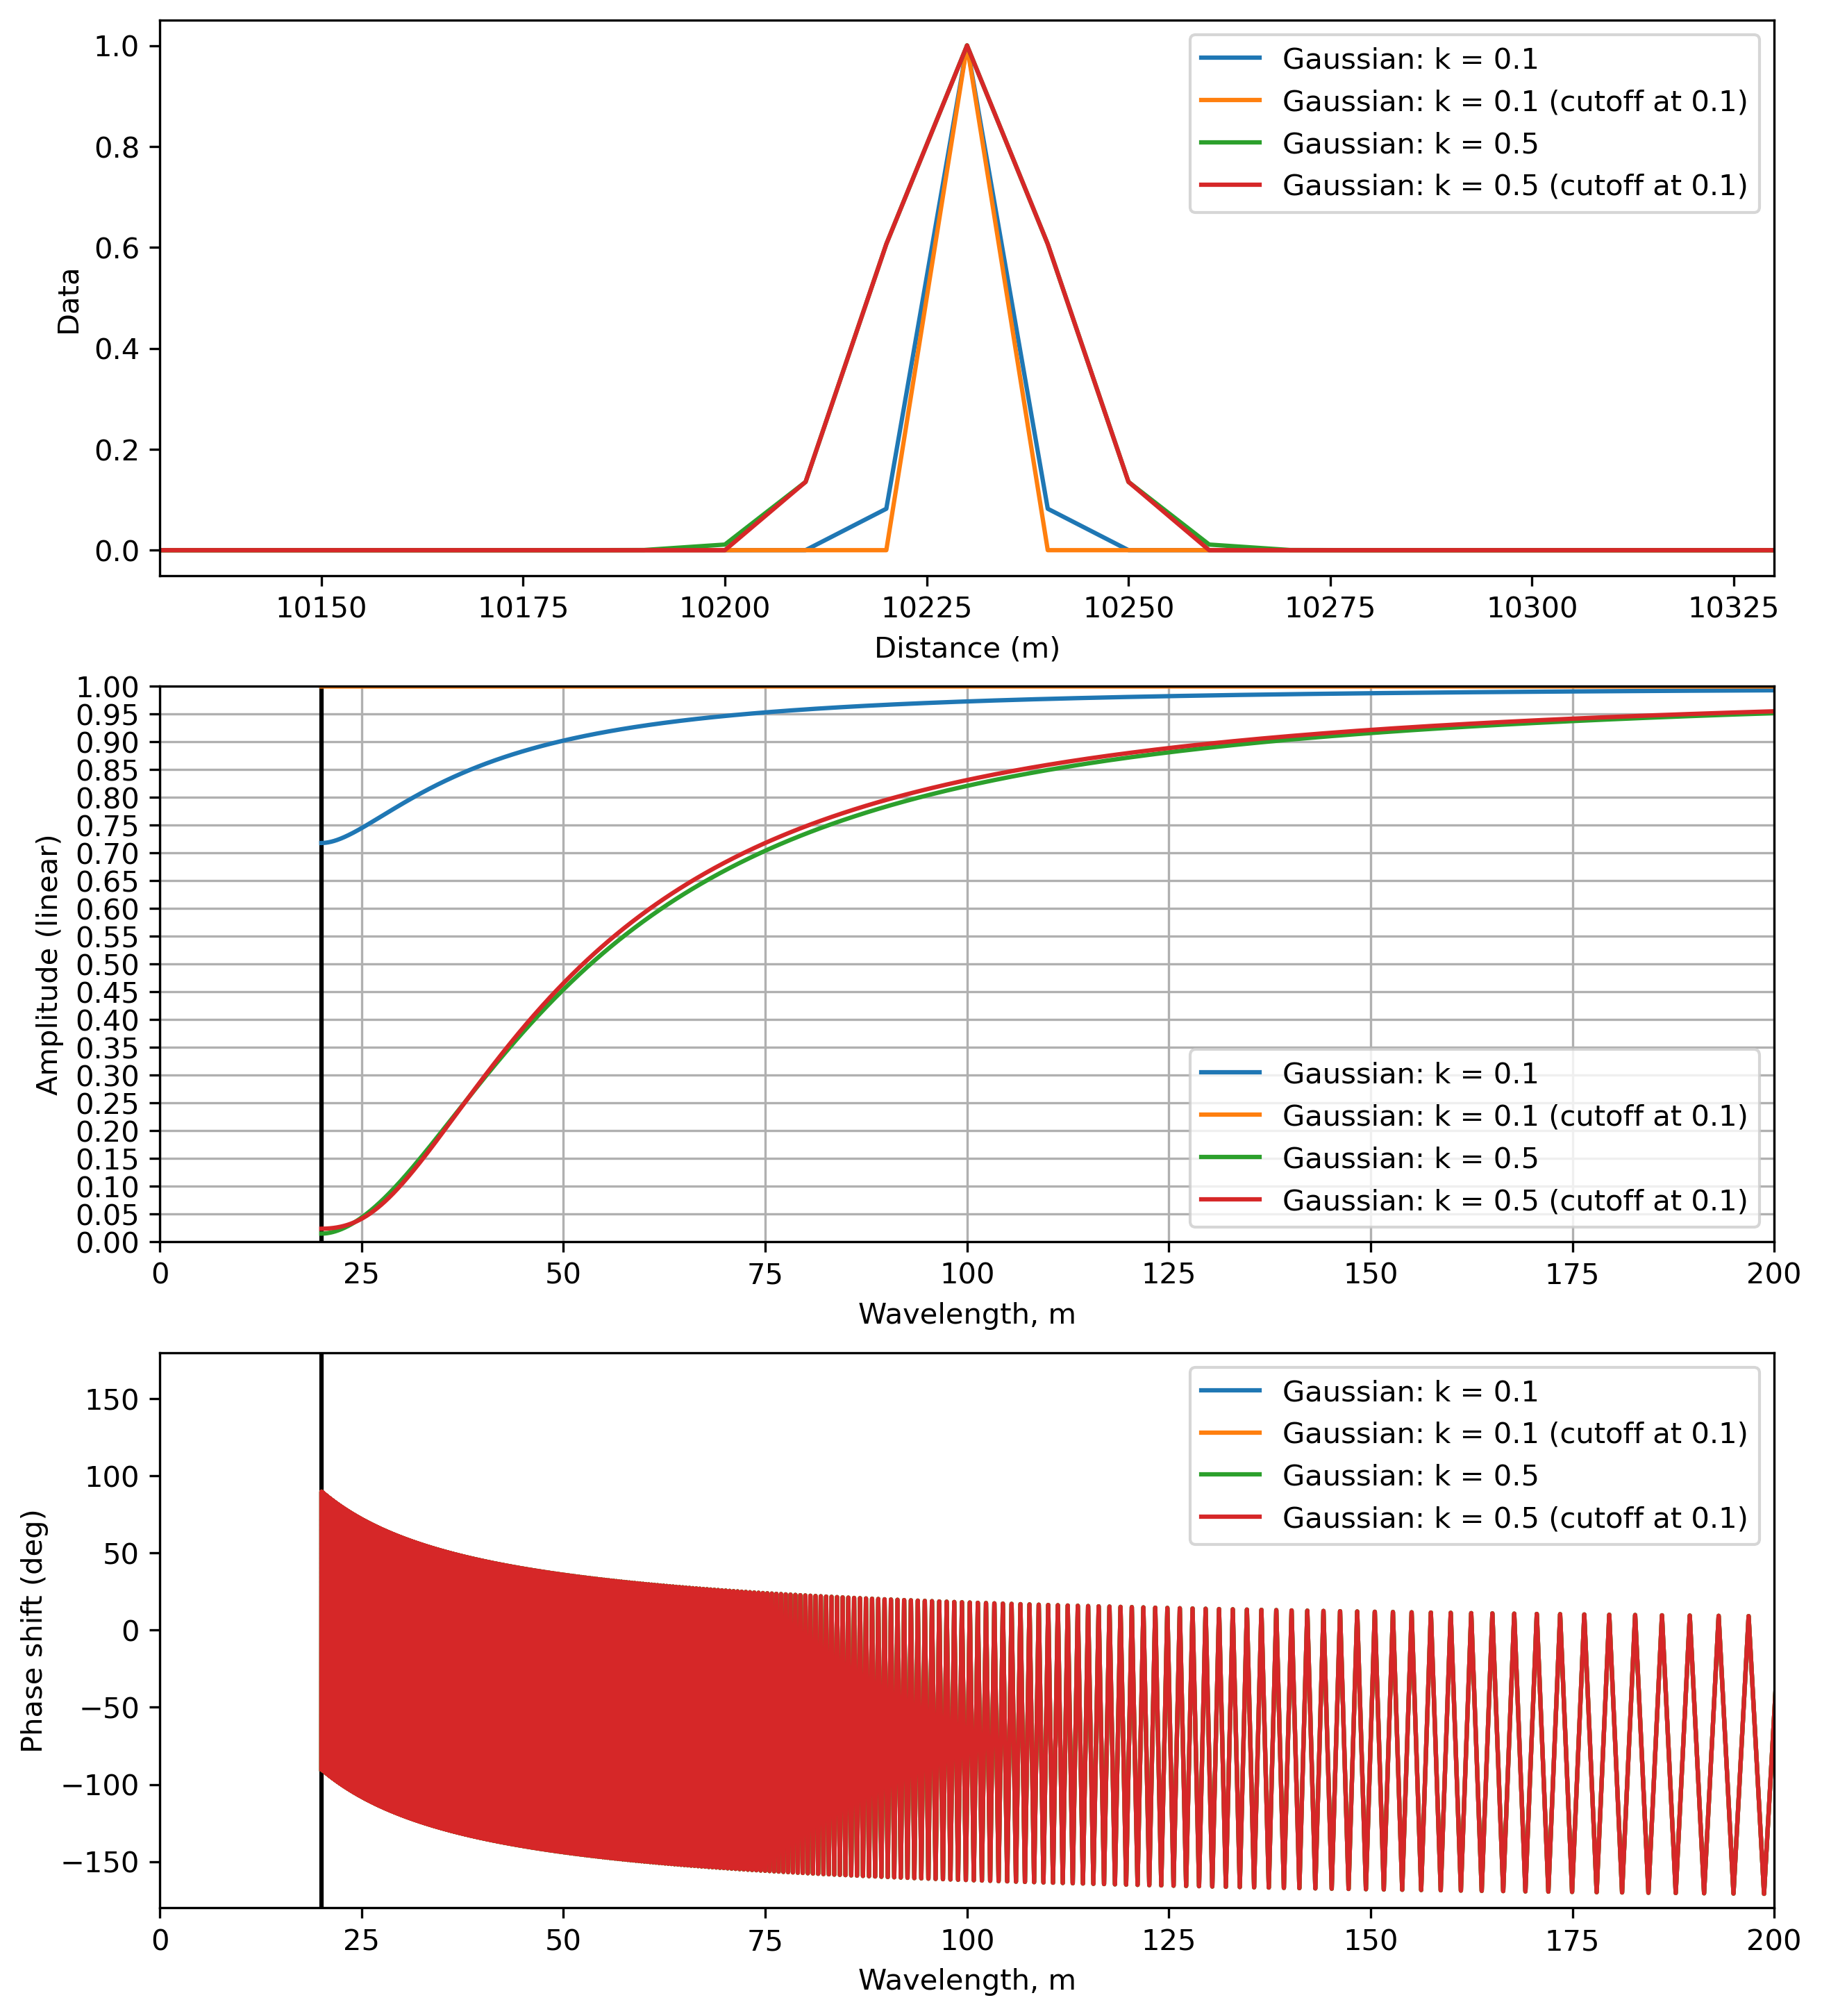

In [154]:
from scipy.signal.windows import gaussian

def sigma(kStar):
    return np.sqrt(2*kStar)

g1 = gaussian(N, sigma(k1))
g2 = gaussian(N, sigma(k2))

g1cut = cutoff(g1)
g2cut = cutoff(g2)

fig, axes = plt.subplots(3,1, figsize=(10,12), dpi=300)

axes[1].grid()

signals = [g1,g1cut,g2,g2cut]
labels = ['Gaussian: k = 0.1', 'Gaussian: k = 0.1 (cutoff at 0.1)',
          'Gaussian: k = 0.5', 'Gaussian: k = 0.5 (cutoff at 0.1)']

response_plot(signals[:], x, axes, freqs, labels=labels[:], wavelength=True, dB_amp = False)
axes[0].set_xlim(x.max()/2-100, x.max()/2+100)
axes[1].set_xlim(0,200)
axes[2].set_xlim(0,200)